# 1. Install & Import Dependencies

In [1]:
import os
import json
import random
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pickle

import pandas as pd

# Optional: optuna for HPO (install if needed)
try:
    import optuna
    OPTUNA_AVAILABLE = True
except Exception:
    OPTUNA_AVAILABLE = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Using device: {DEVICE}")

import shutil
from IPython.display import FileLink

Using device: cuda


# 2. Create Organized Output Structure

In [2]:
def create_output_structure():
    """Create organized output folder structure for ENCODER+SSL"""
    base_dirs = {
        'outputs': 'ENCODER_SSL_BEATS',
        'default_encoder': 'ENCODER_SSL_BEATS/Default_ENCODER_SSL',
        'default_models': 'ENCODER_SSL_BEATS/Default_ENCODER_SSL/Model_Save',
        'default_history': 'ENCODER_SSL_BEATS/Default_ENCODER_SSL/Training_History',
        'default_matrix': 'ENCODER_SSL_BEATS/Default_ENCODER_SSL/Matrix',
        'hpo_encoder': 'ENCODER_SSL_BEATS/HPO_ENCODER_SSL',
        'hpo_models': 'ENCODER_SSL_BEATS/HPO_ENCODER_SSL/Model_Save',
        'hpo_history': 'ENCODER_SSL_BEATS/HPO_ENCODER_SSL/Training_History',
        'hpo_matrix': 'ENCODER_SSL_BEATS/HPO_ENCODER_SSL/Matrix',
    }
    
    for dir_path in base_dirs.values():
        os.makedirs(dir_path, exist_ok=True)
    
    return base_dirs

def create_class_mapping_json(classes, save_path='ENCODER_SSL_BEATS/class_mapping.json'):
    """Create class mapping JSON file"""
    class_mapping = {
        'classes': classes,
        'class_to_idx': {cls: idx for idx, cls in enumerate(classes)},
        'idx_to_class': {idx: cls for idx, cls in enumerate(classes)},
        'description': {
            'N': 'Normal Beat',
            'R': 'Right Bundle Branch Block Beat',
            'Q': 'Unclassifiable Beat',
            'V': 'Ventricular Ectopic Beat',
            'L': 'Left Bundle Branch Block Beat'
        }
    }
    
    with open(save_path, 'w') as f:
        json.dump(class_mapping, f, indent=2)
    
    print(f"Class mapping saved to {save_path}")
    return class_mapping

def create_readme_file(save_path='ENCODER_SSL_BEATS/README.md'):
    """Create comprehensive README file for ENCODER+SSL"""
    readme_content = """# ECG Beat Classification with ENCODER + Self-Supervised Learning (ENCODER+SSL)

This project implements ECG beat classification using a ENCODER-based architecture with Self-Supervised Learning approach for comprehensive evaluation and comparison between default configuration and hyperparameter-optimized models.

## Project Structure

```
ENCODER_SSL_BEATS/
├── README.md                           # This file
├── class_mapping.json                  # Class labels and descriptions
├── config_default.json                 # Default configuration parameters
├── config_hpo.json                     # Best hyperparameters from tuning
├── detailed_metrics_comparison.xlsx    # Comprehensive metrics comparison
│
├── Default_ENCODER_SSL/                   # Default ENCODER+SSL model results
│   ├── Model_Save/                     # Trained model files
│   │   ├── fold1.pth                   # Model weights for fold 1
│   │   ├── fold2.pth                   # Model weights for fold 2
│   │   ├── fold3.pth                   # Model weights for fold 3
│   │   ├── fold4.pth                   # Model weights for fold 4
│   │   └── fold5.pth                   # Model weights for fold 5
│   │
│   ├── Training_History/               # Training progress visualization
│   │   ├── training_history_per_fold.png  # Loss/accuracy plots for all folds
│   │   ├── fold1_history.png           # Individual fold training history
│   │   ├── fold2_history.png
│   │   ├── fold3_history.png
│   │   ├── fold4_history.png
│   │   └── fold5_history.png
│   │
│   └── Matrix/                         # Confusion matrices and evaluation
│       ├── aggregated_confusion_matrix.png     # Combined results
│       ├── train_confusion_matrix.png          # Training set evaluation
│       ├── test_confusion_matrix.png           # Test set evaluation
│       ├── fold1_train_confusion_matrix.png    # Per-fold training matrices
│       ├── fold1_val_confusion_matrix.png      # Per-fold validation matrices
│       ├── fold1_test_confusion_matrix.png     # Per-fold test matrices
│       └── ... (similar for folds 2-5)
│
└── HPO_ENCODER_SSL/                       # Hyperparameter-optimized ENCODER+SSL results
    ├── Model_Save/                     # Same structure as Default_ENCODER_SSL
    ├── Training_History/
    └── Matrix/
```

## Dataset Classes

The model classifies ECG beats into 5 categories:
- **N**: Normal Beat
- **R**: Right Bundle Branch Block Beat  
- **Q**: Unclassifiable Beat
- **V**: Ventricular Ectopic Beat
- **L**: Left Bundle Branch Block Beat

## Model Architecture: ENCODER + Self-Supervised Learning

### Architecture Overview:
- **Base Model**: ENCODER-like Transformer with SSL
- **Input**: 1D ECG beat signals (variable length, padded to max length in batch)
- **Patch Size**: Configurable (default: 16)
- **Hidden Dimension**: Configurable (default: 128)
- **Attention Heads**: Configurable (default: 4)
- **Transformer Layers**: Configurable (default: 6)
- **MLM Masking Ratio**: Configurable (default: 0.15)

### Self-Supervised Learning Components:
1. **Contrastive Loss**: Maximizes agreement between augmented views of the same sample
2. **Masked Language Modeling (MLM)**: ENCODER-style masked token prediction
3. **Combined Training**: Multi-task learning with weighted loss combination

### Training Strategy:
- **Two-Phase Training**:
  - Phase 1: Self-supervised pretraining with contrastive + MLM loss
  - Phase 2: Fine-tuning with classification loss
- **Data Augmentation**: Time-shifting, amplitude scaling, noise injection for contrastive learning

## Training Strategy

### 5-Fold Cross Validation
- Stratified splitting to maintain class balance
- Each fold trained for specified epochs
- Best fold selected based on validation accuracy

### Two Training Approaches:
1. **Default Configuration**: Pre-defined hyperparameters
2. **Hyperparameter Optimization**: Optuna-based tuning with 3-fold inner CV

### Optimization Details
- **Optimizer**: AdamW
- **Loss Functions**: 
  - Contrastive Loss (Self-Supervised)
  - Masked Language Modeling Loss (ENCODER)
  - CrossEntropyLoss (Classification)
- **Learning Rate**: Tunable (default: 1e-3)
- **Weight Decay**: Tunable (default: 1e-4)
- **Batch Size**: Configurable (default: 64)
- **SSL Weight**: Balance between SSL and supervised loss (default: 0.5)

## Evaluation Metrics

### Per-Class Metrics:
- **Accuracy**: (TP + TN) / (TP + TN + FP + FN) per class
- **Sensitivity (Recall)**: TP / (TP + FN) per class
- **Specificity**: TN / (TN + FP) per class  
- **F1-Score**: 2 * (Precision * Recall) / (Precision + Recall) per class

### Aggregated Metrics:
- **Overall Accuracy**: Mean of per-class accuracies
- **Macro Average**: Unweighted mean of per-class metrics
- **Weighted Average**: Sample-weighted mean of per-class metrics

## Files Description

### Configuration Files
- `config_default.json`: Default hyperparameters and settings
- `config_hpo.json`: Best hyperparameters found through optimization
- `class_mapping.json`: Class labels and descriptions

### Model Files
- `Default_ENCODER_SSL/Model_Save/fold*.pth`: Trained model weights for each fold
- `HPO_ENCODER_SSL/Model_Save/fold*.pth`: Optimized model weights for each fold

### Results Files
- `detailed_metrics_comparison.xlsx`: Comprehensive metrics comparison with sheets:
  - Default_Train_ENCODER_SSL: Training metrics for all folds (Default)
  - Tuning_Train_ENCODER_SSL: Training metrics for all folds (HPO)
  - Default_Test_ENCODER_SSL: Test metrics for best Default fold
  - Tuning_Test_ENCODER_SSL: Test metrics for best HPO fold

### Visualization Files
- Training history plots showing loss and accuracy progression
- Confusion matrices for train, validation, and test sets
- Per-fold and aggregated evaluation visualizations

## Usage

1. **Load Best Model**:
   ```python
   # Load best fold from either Default or HPO
   model_path = "ENCODER_SSL_BEATS/Default_ENCODER_SSL/Model_Save/fold{best_fold}.pth" 
   model.load_state_dict(torch.load(model_path))
   ```

2. **View Configuration**:
   ```python
   with open('ENCODER_SSL_BEATS/config_default.json', 'r') as f:
       config = json.load(f)
   ```

3. **Load Class Mapping**:
   ```python
   with open('ENCODER_SSL_BEATS/class_mapping.json', 'r') as f:
       class_info = json.load(f)
   ```

## Performance Summary

The project compares Default ENCODER+SSL vs Hyperparameter-Optimized ENCODER+SSL across:
- **Training Performance**: 5-fold cross-validation results
- **Generalization**: Test set evaluation on best fold
- **Robustness**: Per-class performance analysis
- **Efficiency**: Training convergence and stability
- **SSL Benefits**: Improved feature learning through self-supervision

Best models are selected based on validation accuracy and evaluated on held-out test set for final performance assessment.

## Dependencies

- PyTorch
- scikit-learn  
- NumPy
- Pandas
- Matplotlib
- Seaborn
- Optuna (optional, for hyperparameter optimization)

## Notes

- All models use the same random seed for reproducibility
- Stratified splitting ensures balanced class representation
- Per-beat normalization applied (z-score normalization)
- Variable-length sequences handled via padding in batch collation
- Self-supervised learning enhances representation quality
- ENCODER-style masking improves contextual understanding
"""
    
    with open(save_path, 'w') as f:
        f.write(readme_content)
    
    print(f"README.md created at {save_path}")

# Create output structure
OUTPUT_DIRS = create_output_structure()
print("Created organized output directory structure")

Created organized output directory structure


# 3. Load Datasets

=== Dataset Distribution (Train) ===
L         : 5600
N         : 5600
Q         : 5600
R         : 5600
V         : 5600

=== Dataset Distribution (Test) ===
L         : 1400
N         : 1400
Q         : 1400
R         : 1400
V         : 1400


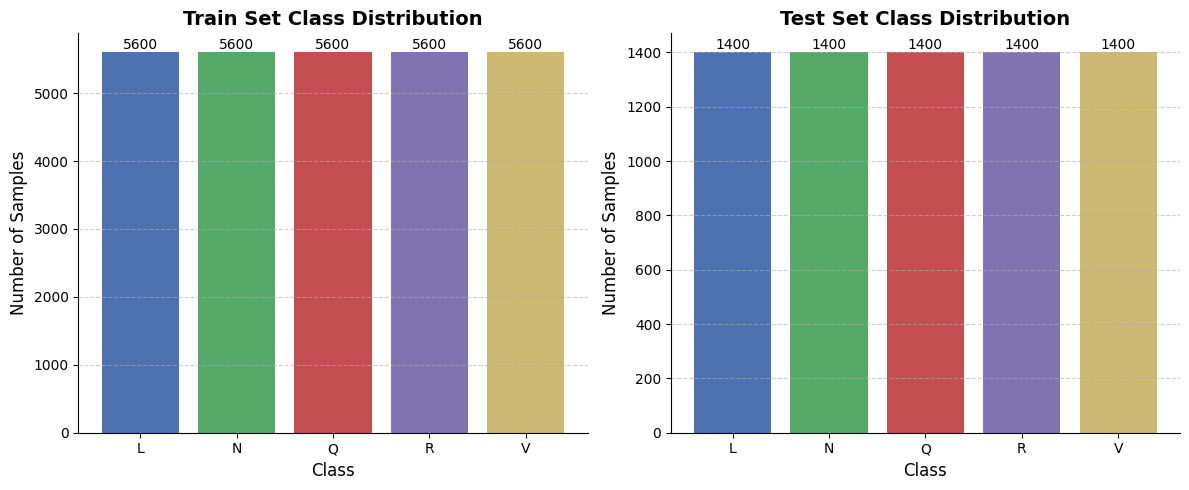

In [3]:
base_dir = '/kaggle/input/SPLIT_BEATS_NPY'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'Beats_TEST')

def count_files_per_class(directory):
    """Count the number of files per class in a given directory."""
    counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

# Count data per class
train_counts = count_files_per_class(train_dir)
test_counts = count_files_per_class(test_dir)

# Display in console
print("=== Dataset Distribution (Train) ===")
for k, v in train_counts.items():
    print(f"{k:<10}: {v}")

print("\n=== Dataset Distribution (Test) ===")
for k, v in test_counts.items():
    print(f"{k:<10}: {v}")

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
bar_colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']

# Plot Train
axes[0].bar(train_counts.keys(), train_counts.values(), color=bar_colors)
axes[0].set_title('Train Set Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)

# Add numbers on bars (Train)
for i, value in enumerate(train_counts.values()):
    axes[0].text(i, value + 3, str(value), ha='center', va='bottom', fontsize=10)

# Plot Test
axes[1].bar(test_counts.keys(), test_counts.values(), color=bar_colors)
axes[1].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)

# Add numbers on bars (Test)
for i, value in enumerate(test_counts.values()):
    axes[1].text(i, value + 3, str(value), ha='center', va='bottom', fontsize=10)

# General styling
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [4]:
class ECGBeatDataset(Dataset):
    """Load .npy beat files and labels. Assumes folder structure where parent folder name is class label."""
    def __init__(self, root_dirs: List[Path], classes: List[str], transform=None):
        self.files = []
        self.labels = []
        self.classes = classes
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        for root in root_dirs:
            root = Path(root)
            if not root.exists():
                continue
            for p in root.glob('**/*.npy'):
                try:
                    cls = p.parent.name
                    if cls not in self.class_to_idx:
                        fname = p.name
                        if fname[0] in self.class_to_idx:
                            cls = fname[0]
                        else:
                            continue
                    self.files.append(str(p))
                    self.labels.append(self.class_to_idx[cls])
                except Exception:
                    continue
        assert len(self.files) == len(self.labels), "files/labels mismatch"
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        arr = np.load(self.files[idx])
        arr = np.asarray(arr, dtype=np.float32).squeeze()
        if arr.std() > 0:
            arr = (arr - arr.mean()) / (arr.std() + 1e-8)
        label = int(self.labels[idx])
        x = torch.from_numpy(arr).float()
        return x, label

# 4. Config

In [5]:
DEFAULT_CONFIG = {
    "seed": 42,
    "dataset": {
        "train_dirs": ["/kaggle/input/SPLIT_BEATS_NPY/train"],
        "test_dirs": ["/kaggle/input/SPLIT_BEATS_NPY/Beats_TEST"],
        "classes": ["N","R","Q","V","L"],
    },
    "training": {
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "batch_size": 64,
        "num_epochs": 20,
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "num_workers": 20,
        "ssl_weight": 0.5,  # Weight for reconstruction loss
        "pretrain_epochs": 2,
    },
    "model": {
        "patch_size": 16,
        "hidden_dim": 128,
        "n_heads": 4,
        "n_layers": 6,
        "mlm_mask_ratio": 0.15,
        "dropout": 0.1,
        "projection_dim": 64,  # Projection dimension for contrastive learning
        "temperature": 0.07,   # Temperature for contrastive loss
    },
}

# Save configuration
os.makedirs('ENCODER_SSL_BEATS', exist_ok=True)
with open('ENCODER_SSL_BEATS/config_default.json', 'w') as f:
    json.dump(DEFAULT_CONFIG, f, indent=2)


# Create class mapping and README
create_class_mapping_json(DEFAULT_CONFIG['dataset']['classes'])
create_readme_file()

# Utilities
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(DEFAULT_CONFIG['seed'])


def collate_ecg(batch):
    """Pad to max length in batch to enable batching if beats vary in length."""
    xs, ys = zip(*batch)
    lengths = [x.shape[0] for x in xs]
    maxlen = max(lengths)
    batch_x = torch.zeros(len(xs), maxlen)
    for i, x in enumerate(xs):
        batch_x[i, :x.shape[0]] = x
    return batch_x.unsqueeze(1), torch.tensor(ys, dtype=torch.long)

Class mapping saved to ENCODER_SSL_BEATS/class_mapping.json
README.md created at ENCODER_SSL_BEATS/README.md


# 5. Load Pre-Train Model Transformer ENCODER+SSL

In [6]:
class PatchEmbed1D(nn.Module):
    """1D Patch Embedding for ECG signals"""
    def __init__(self, in_chans=1, patch_size=16, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv1d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, num_patches)
        x = x.permute(0, 2, 1)  # (B, num_patches, embed_dim)
        return x


class ProjectionHead(nn.Module):
    """Projection head for contrastive learning"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)


class ECGAugmentation:
    """Augmentation strategies for ECG signals in SSL"""
    @staticmethod
    def time_shift(x, shift_max=0.1):
        """Random time shifting"""
        B, N, D = x.shape
        shift = int(shift_max * N)
        if shift > 0:
            shift = torch.randint(-shift, shift + 1, (1,)).item()
            if shift > 0:
                x = torch.cat([x[:, shift:], x[:, :shift]], dim=1)
            elif shift < 0:
                x = torch.cat([x[:, shift:], x[:, :shift]], dim=1)
        return x
    
    @staticmethod
    def amplitude_scale(x, scale_range=(0.8, 1.2)):
        """Random amplitude scaling"""
        scale = torch.FloatTensor(1).uniform_(*scale_range).to(x.device)
        return x * scale
    
    @staticmethod
    def add_noise(x, noise_std=0.01):
        """Add Gaussian noise"""
        noise = torch.randn_like(x) * noise_std
        return x + noise
    
    @staticmethod
    def augment(x):
        """Apply multiple augmentations"""
        x = ECGAugmentation.time_shift(x)
        x = ECGAugmentation.amplitude_scale(x)
        x = ECGAugmentation.add_noise(x)
        return x


class EncoderBlock(nn.Module):
    """Single Encoder Block with Multi-Head Attention"""
    def __init__(self, hidden_dim, n_heads, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        # Multi-head attention with residual
        attn_out, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_out)
        
        # Feed-forward with residual
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        return x


class ENCODER_SSL(nn.Module):
    """
    Encoder architecture with Self-Supervised Learning for ECG classification
    
    Architecture:
    1. Patch Embedding: Convert raw ECG to patch embeddings
    2. Positional Encoding: Add positional information
    3. Encoder Stack: Multiple transformer encoder layers
    4. SSL Components: Contrastive learning and reconstruction
    5. Classification Head: Final classifier
    """
    def __init__(self, num_patches, patch_size, cfg):
        super().__init__()
        hidden_dim = cfg['hidden_dim']
        
        # Patch embedding
        self.patch_embed = PatchEmbed1D(in_chans=1, patch_size=patch_size, embed_dim=hidden_dim)
        
        # Positional embedding
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, hidden_dim) * 0.02)
        self.pos_dropout = nn.Dropout(cfg.get('dropout', 0.1))
        
        # Encoder stack
        self.encoder_blocks = nn.ModuleList([
            EncoderBlock(hidden_dim, cfg['n_heads'], cfg.get('dropout', 0.1))
            for _ in range(cfg.get('n_layers', 6))
        ])
        
        # Global pooling token (like CLS token)
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim) * 0.02)
        
        # SSL: Projection head for contrastive learning
        self.projection_head = ProjectionHead(
            input_dim=hidden_dim,
            hidden_dim=hidden_dim,
            output_dim=cfg.get('projection_dim', 64)
        )
        
        # SSL: Reconstruction head for self-supervised reconstruction
        self.reconstruction_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, patch_size)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Dropout(cfg.get('dropout', 0.1)),
            nn.Linear(hidden_dim, len(DEFAULT_CONFIG['dataset']['classes']))
        )
        
        self.temperature = cfg.get('temperature', 0.07)
        self.hidden_dim = hidden_dim

    def forward_encoder(self, x):
        """Forward pass through encoder"""
        B = x.size(0)
        
        # Patch embedding
        patches = self.patch_embed(x)  # (B, num_patches, hidden_dim)
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        patches = torch.cat([cls_tokens, patches], dim=1)  # (B, num_patches+1, hidden_dim)
        
        # Add positional embedding
        if patches.size(1) <= self.pos_embed.size(1):
            patches = patches + self.pos_embed[:, :patches.size(1), :]
        else:
            # If input is longer than expected, interpolate positional embeddings
            pos_embed_expanded = nn.functional.interpolate(
                self.pos_embed.permute(0, 2, 1),
                size=patches.size(1),
                mode='linear',
                align_corners=False
            ).permute(0, 2, 1)
            patches = patches + pos_embed_expanded
        
        patches = self.pos_dropout(patches)
        
        # Pass through encoder blocks
        for block in self.encoder_blocks:
            patches = block(patches)
        
        return patches

    def forward(self, x, mode='pretrain'):
        """
        Forward pass with different modes:
        - pretrain: SSL pretraining (contrastive + reconstruction)
        - finetune: Classification fine-tuning
        - classify: Inference mode
        """
        if mode == 'pretrain':
            # SSL PRETRAINING MODE
            
            # Forward pass
            encoded = self.forward_encoder(x)
            
            # Extract CLS token representation
            cls_repr = encoded[:, 0]  # (B, hidden_dim)
            
            # Projection for contrastive learning
            z = self.projection_head(cls_repr)
            
            # Reconstruction of patches (excluding CLS token)
            patch_repr = encoded[:, 1:, :]  # (B, num_patches, hidden_dim)
            reconstructed = self.reconstruction_head(patch_repr)  # (B, num_patches, patch_size)
            
            return z, reconstructed
            
        else:
            # FINE-TUNING / INFERENCE MODE
            
            # Forward pass
            encoded = self.forward_encoder(x)
            
            # Extract CLS token for classification
            cls_repr = encoded[:, 0]
            
            # Classification
            logits = self.classifier(cls_repr)
            
            return logits, None


class NTXentLoss(nn.Module):
    """Normalized Temperature-scaled Cross Entropy Loss for contrastive learning"""
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, z_i, z_j):
        """
        z_i, z_j: representations from two augmented views (B, projection_dim)
        """
        B = z_i.shape[0]
        
        # Normalize representations
        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)
        
        # Concatenate representations
        z = torch.cat([z_i, z_j], dim=0)  # (2B, projection_dim)
        
        # Compute similarity matrix
        sim_matrix = torch.mm(z, z.t()) / self.temperature  # (2B, 2B)
        
        # Create labels: positive pairs are (i, B+i) and (B+i, i)
        labels = torch.cat([torch.arange(B) + B, torch.arange(B)]).to(z.device)
        
        # Mask out self-similarity
        mask = torch.eye(2 * B, dtype=torch.bool, device=z.device)
        sim_matrix = sim_matrix.masked_fill(mask, -float('inf'))
        
        # Compute loss
        loss = self.criterion(sim_matrix, labels)
        
        return loss

# 6. ENCODER+SSL Default Training with 5-Fold Cross-Validation

In [7]:
def pretrain_one_epoch_ssl(model, loader, optimizer, device, cfg):
    """
    Pretraining with SSL: Contrastive Loss + Reconstruction Loss
    """
    model.train()
    running_contrastive_loss = 0.0
    running_recon_loss = 0.0
    total = 0
    
    contrastive_criterion = NTXentLoss(temperature=cfg['model'].get('temperature', 0.07))
    recon_criterion = nn.MSELoss()
    
    for xb, _ in loader:
        xb = xb.to(device)
        B = xb.size(0)
        
        # Get original patches for reconstruction target
        with torch.no_grad():
            patch_embed = model.patch_embed(xb)  # (B, num_patches, hidden_dim)
            # Use patch embeddings as reconstruction target
            target_patches = patch_embed.detach()
        
        # Create two augmented views (simple augmentation)
        xb_aug1 = xb + torch.randn_like(xb) * 0.01  # Add small noise
        xb_aug2 = xb + torch.randn_like(xb) * 0.01
        
        optimizer.zero_grad()
        
        # Forward pass for both views
        z1, recon1 = model(xb_aug1, mode='pretrain')
        z2, recon2 = model(xb_aug2, mode='pretrain')
        
        # Contrastive loss
        loss_contrastive = contrastive_criterion(z1, z2)
        
        # Reconstruction loss (compare with original patches)
        # Flatten reconstructed patches for MSE comparison
        num_patches = target_patches.size(1)
        patch_size = recon1.size(-1)
        
        # Simple reconstruction loss on patch representations
        loss_recon = recon_criterion(
            recon1.reshape(B, -1), 
            target_patches.reshape(B, -1)[:, :recon1.reshape(B, -1).size(1)]
        )
        
        # Combined loss (weighted)
        ssl_weight = cfg['training'].get('ssl_weight', 0.5)
        loss = loss_contrastive + ssl_weight * loss_recon
        
        loss.backward()
        optimizer.step()
        
        running_contrastive_loss += loss_contrastive.item() * B
        running_recon_loss += loss_recon.item() * B
        total += B
    
    return running_contrastive_loss/total, running_recon_loss/total


def train_one_epoch(model, loader, optimizer, device):
    """Fine-tuning with classification loss"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    criterion_cls = nn.CrossEntropyLoss()
    
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        
        logits, _ = model(xb, mode='finetune')
        loss = criterion_cls(logits, yb)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * xb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)
    
    return running_loss/total, correct/total


def validate(model, loader, device):
    """Validation function"""
    model.eval()
    running_loss = 0.0
    preds = []
    trues = []
    criterion_cls = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            
            logits, _ = model(xb, mode='classify')
            loss = criterion_cls(logits, yb)
            
            running_loss += loss.item() * xb.size(0)
            pred = logits.argmax(dim=1)
            preds.extend(pred.cpu().numpy().tolist())
            trues.extend(yb.cpu().numpy().tolist())
    
    acc = accuracy_score(trues, preds)
    return running_loss/len(trues), acc, preds, trues



def run_5fold_training(cfg, default_run_name='default_encoder_ssl'):
    """5-fold training with SSL pretraining phase for Encoder+SSL"""
    device = cfg['training']['device']
    dataset = ECGBeatDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    X = list(range(len(dataset)))
    y = dataset.labels
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg['seed'])

    fold_results = {}
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        fold = fold + 1
        print(f"\n{'='*80}")
        print(f"Starting fold {fold} - Encoder+SSL Training")
        print('='*80)
        
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(
            train_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=True, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )
        val_loader = DataLoader(
            val_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=False, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )

        sample_x, _ = dataset[train_idx[0]]
        L = sample_x.shape[0]
        patch_size = cfg['model']['patch_size']
        num_patches = (L + patch_size - 1) // patch_size

        # Use Encoder_SSL instead of ENCODER_SSL
        model = ENCODER_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=cfg['training']['learning_rate'], 
                               weight_decay=cfg['training']['weight_decay'])

        history = {
            'pretrain_contrastive_loss': [],
            'pretrain_recon_loss': [],
            'train_loss': [], 
            'train_acc': [], 
            'val_loss': [], 
            'val_acc': []
        }
        
        # Phase 1 - SSL Pretraining
        pretrain_epochs = cfg['training'].get('pretrain_epochs', 20)
        print(f"\n--- Phase 1: SSL Pretraining ({pretrain_epochs} epochs) ---")
        
        for epoch in range(pretrain_epochs):
            epoch_num = epoch + 1
            contrastive_loss, recon_loss = pretrain_one_epoch_ssl(model, train_loader, optimizer, device, cfg)
            history['pretrain_contrastive_loss'].append(contrastive_loss)
            history['pretrain_recon_loss'].append(recon_loss)
            print(f"Pretrain Epoch {epoch_num}/{pretrain_epochs}: contrastive={contrastive_loss:.4f} recon={recon_loss:.4f}")
        
        # Phase 2 - Fine-tuning with Classification
        finetune_epochs = cfg['training']['num_epochs']
        print(f"\n--- Phase 2: Classification Fine-tuning ({finetune_epochs} epochs) ---")
        
        for epoch in range(finetune_epochs):
            epoch_num = epoch + 1
            tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, device)
            val_loss, val_acc, _, _ = validate(model, val_loader, device)
            
            history['train_loss'].append(tr_loss)
            history['train_acc'].append(tr_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            print(f"Finetune Epoch {epoch_num}/{finetune_epochs}: tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

        val_loss, val_acc, preds, trues = validate(model, val_loader, device)
        fold_results[fold] = {
            'model_state_dict': model.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'preds': preds,
            'trues': trues,
            'history': history,
        }
        
        # Update save paths for Encoder_SSL
        models_dir = OUTPUT_DIRS['default_models'] if 'default' in default_run_name.lower() else \
            OUTPUT_DIRS['hpo_models'] if 'hpo' in default_run_name.lower() else 'outputs'

        torch.save(model.state_dict(), f'{models_dir}/{default_run_name}_fold{fold}.pth')
        with open(f'{models_dir}/{default_run_name}_fold{fold}_results.pkl', 'wb') as f:
            pickle.dump(fold_results[fold], f)

    with open(f'{models_dir}/{default_run_name}_all_folds.pkl', 'wb') as f:
        pickle.dump(fold_results, f)
    
    return fold_results

# 7. Hyperparameter Tuning & 5-Fold Cross-Validation

In [8]:
def objective(trial, base_cfg):
    """Objective function for HPO with SSL parameters"""
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 192])
    n_heads = trial.suggest_categorical('n_heads', [2, 4, 8])
    mlm_mask_ratio = trial.suggest_uniform('mlm_mask_ratio', 0.10, 0.25)
    ssl_weight = trial.suggest_uniform('ssl_weight', 0.1, 0.9)
    temperature = trial.suggest_uniform('temperature', 0.05, 0.2)

    cfg = json.loads(json.dumps(base_cfg))
    cfg['training']['learning_rate'] = lr
    cfg['training']['weight_decay'] = weight_decay
    cfg['training']['ssl_weight'] = ssl_weight
    cfg['model']['hidden_dim'] = hidden_dim
    cfg['model']['n_heads'] = n_heads
    cfg['model']['mlm_mask_ratio'] = mlm_mask_ratio
    cfg['model']['temperature'] = temperature

    device = cfg['training']['device']
    dataset = ECGBeatDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    X = list(range(len(dataset)))
    y = dataset.labels
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=cfg['seed'])

    val_scores = []
    for _, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(
            train_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=True, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )
        val_loader = DataLoader(
            val_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=False, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )

        sample_x, _ = dataset[train_idx[0]]
        L = sample_x.shape[0]
        patch_size = cfg['model']['patch_size']
        num_patches = (L + patch_size - 1) // patch_size

        model = ENCODER_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=cfg['training']['learning_rate'], weight_decay=cfg['training']['weight_decay'])

        for _ in range(2):
            _ = pretrain_one_epoch_ssl(model, train_loader, optimizer, device, cfg)
        
        for _ in range(min(5, cfg['training']['num_epochs'])):
            _ = train_one_epoch(model, train_loader, optimizer, device)
        
        _, val_acc, _, _ = validate(model, val_loader, device)
        val_scores.append(val_acc)

    return float(np.mean(val_scores))


def run_hyperparam_search(base_cfg, n_trials=20, timeout=180):
    """Hyperparameter search"""
    if not OPTUNA_AVAILABLE:
        raise RuntimeError('Optuna not installed. Install optuna to run hyperparameter search.')
    
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda t: objective(t, base_cfg), n_trials=n_trials, timeout=timeout)
    
    print('Best trial:', study.best_trial.params)
    
    best_params = study.best_trial.params
    base_cfg['training']['learning_rate'] = best_params['lr']
    base_cfg['training']['weight_decay'] = best_params['weight_decay']
    base_cfg['training']['ssl_weight'] = best_params.get('ssl_weight', 0.5)
    base_cfg['model']['hidden_dim'] = best_params['hidden_dim']
    base_cfg['model']['n_heads'] = best_params['n_heads']
    base_cfg['model']['mlm_mask_ratio'] = best_params['mlm_mask_ratio']
    base_cfg['model']['temperature'] = best_params.get('temperature', 0.07)
    
    with open('ENCODER_SSL_BEATS/config_hpo.json', 'w') as f:
        json.dump(base_cfg, f, indent=2)
    
    return base_cfg, study

# 8. Training

In [9]:
def plot_history(history, title, filename=None):
    """Plot history including SSL pretraining losses"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1 = axes[0]
    epochs_finetune = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs_finetune, history['train_loss'], 'b-', label='Train Loss', marker='o')
    ax1.plot(epochs_finetune, history['val_loss'], 'r-', label='Val Loss', marker='s')
    ax1.set_xlabel('Fine-tuning Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Classification Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax1_twin = ax1.twinx()
    ax1_twin.plot(epochs_finetune, history['train_acc'], 'g--', label='Train Acc', marker='^')
    ax1_twin.plot(epochs_finetune, history['val_acc'], 'm--', label='Val Acc', marker='v')
    ax1_twin.set_ylabel('Accuracy')
    ax1_twin.legend(loc='lower right')
    
    ax2 = axes[1]
    if len(history.get('pretrain_contrastive_loss', [])) > 0:
        epochs_pretrain = range(1, len(history['pretrain_contrastive_loss']) + 1)
        ax2.plot(epochs_pretrain, history['pretrain_contrastive_loss'], 'purple', label='Contrastive Loss', marker='o')
        ax2.plot(epochs_pretrain, history['pretrain_recon_loss'], 'orange', label='MLM Loss', marker='s')
        ax2.set_xlabel('Pretraining Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_title(f'{title} - SSL Pretraining Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()


def summarize_folds(fold_results, name_prefix):
    """Aggregate fold metrics and plot"""
    all_acc = []
    for f, d in fold_results.items():
        all_acc.append(d['val_acc'])
        
        history_dir = OUTPUT_DIRS['default_history'] if 'default_encoder_ssl' in name_prefix.lower() else \
            OUTPUT_DIRS['hpo_history'] if 'hpo_encoder_ssl' in name_prefix.lower() else OUTPUT_DIRS['outputs']
        
        plot_history(d['history'], f"{name_prefix} Fold {f}", filename=f'{history_dir}/{name_prefix}_fold{f}_history.png')
    
    print(f"{name_prefix} mean val acc: {np.mean(all_acc):.4f} +/- {np.std(all_acc):.4f}")


def classification_report_and_cm(trues, preds, classes, prefix):
    """Generate classification report and confusion matrix"""
    print(f"--- Report: {prefix} ---")
    print(classification_report(trues, preds, target_names=classes))
    
    cm = confusion_matrix(trues, preds)
    print('Confusion Matrix:')
    
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f'Confusion Matrix (Test) - {prefix}')
    plt.colorbar()
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > cm.max()/2 else "black")
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    
    matrix_dir = OUTPUT_DIRS['default_matrix'] if 'default' in prefix.lower() else \
        OUTPUT_DIRS['hpo_matrix'] if 'hpo' in prefix.lower() else 'outputs'
    
    plt.savefig(f'{matrix_dir}/{prefix}_confusion_matrix.png')
    plt.close()
    
    img = mpimg.imread(f'{matrix_dir}/{prefix}_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 8.1. Default ENCODER+SSL (5-Fold Training)


Starting DEFAULT ENCODER+SSL 5-Fold training...

Starting fold 1 - Encoder+SSL Training


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- Phase 1: SSL Pretraining (2 epochs) ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Pretrain Epoch 1/2: contrastive=0.3709 recon=0.0500
Pretrain Epoch 2/2: contrastive=0.0959 recon=0.0496

--- Phase 2: Classification Fine-tuning (20 epochs) ---
Finetune Epoch 1/20: tr_loss=0.3818 tr_acc=0.8696 val_loss=0.1251 val_acc=0.9657


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 2/20: tr_loss=0.1443 tr_acc=0.9559 val_loss=0.1338 val_acc=0.9587


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 3/20: tr_loss=0.1258 tr_acc=0.9610 val_loss=0.1109 val_acc=0.9707


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 4/20: tr_loss=0.0925 tr_acc=0.9715 val_loss=0.1012 val_acc=0.9718


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 5/20: tr_loss=0.1061 tr_acc=0.9675 val_loss=0.0955 val_acc=0.9727


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 6/20: tr_loss=0.0933 tr_acc=0.9726 val_loss=0.0843 val_acc=0.9759


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 7/20: tr_loss=0.0832 tr_acc=0.9756 val_loss=0.0819 val_acc=0.9761


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 8/20: tr_loss=0.0887 tr_acc=0.9737 val_loss=0.1155 val_acc=0.9696


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 9/20: tr_loss=0.0879 tr_acc=0.9732 val_loss=0.0599 val_acc=0.9818


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 10/20: tr_loss=0.1012 tr_acc=0.9708 val_loss=0.0857 val_acc=0.9770


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 11/20: tr_loss=0.0905 tr_acc=0.9738 val_loss=0.0758 val_acc=0.9771


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 12/20: tr_loss=0.0787 tr_acc=0.9771 val_loss=0.0805 val_acc=0.9771


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 13/20: tr_loss=0.0780 tr_acc=0.9762 val_loss=0.0635 val_acc=0.9825


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 14/20: tr_loss=0.0752 tr_acc=0.9774 val_loss=0.1439 val_acc=0.9629


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 15/20: tr_loss=0.0644 tr_acc=0.9805 val_loss=0.0580 val_acc=0.9830


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 16/20: tr_loss=0.0733 tr_acc=0.9779 val_loss=0.0789 val_acc=0.9761


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 17/20: tr_loss=0.0734 tr_acc=0.9771 val_loss=0.0573 val_acc=0.9832


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 18/20: tr_loss=0.0610 tr_acc=0.9818 val_loss=0.0489 val_acc=0.9861


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 19/20: tr_loss=0.0680 tr_acc=0.9796 val_loss=0.0628 val_acc=0.9845


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 20/20: tr_loss=0.0612 tr_acc=0.9813 val_loss=0.0554 val_acc=0.9873


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Starting fold 2 - Encoder+SSL Training

--- Phase 1: SSL Pretraining (2 epochs) ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Pretrain Epoch 1/2: contrastive=0.3712 recon=0.0523
Pretrain Epoch 2/2: contrastive=0.0822 recon=0.0502

--- Phase 2: Classification Fine-tuning (20 epochs) ---
Finetune Epoch 1/20: tr_loss=0.3709 tr_acc=0.8754 val_loss=0.1878 val_acc=0.9436


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 2/20: tr_loss=0.1431 tr_acc=0.9565 val_loss=0.0958 val_acc=0.9698


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 3/20: tr_loss=0.1094 tr_acc=0.9663 val_loss=0.0940 val_acc=0.9718


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 4/20: tr_loss=0.0967 tr_acc=0.9716 val_loss=0.0792 val_acc=0.9755


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 5/20: tr_loss=0.0928 tr_acc=0.9724 val_loss=0.0860 val_acc=0.9754


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 6/20: tr_loss=0.0992 tr_acc=0.9705 val_loss=0.0575 val_acc=0.9839


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 7/20: tr_loss=0.0811 tr_acc=0.9760 val_loss=0.0889 val_acc=0.9738


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 8/20: tr_loss=0.0888 tr_acc=0.9737 val_loss=0.1082 val_acc=0.9677


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 9/20: tr_loss=0.0967 tr_acc=0.9733 val_loss=0.1134 val_acc=0.9673


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 10/20: tr_loss=0.0900 tr_acc=0.9745 val_loss=0.0953 val_acc=0.9739


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 11/20: tr_loss=0.0809 tr_acc=0.9768 val_loss=0.0589 val_acc=0.9825


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 12/20: tr_loss=0.0712 tr_acc=0.9789 val_loss=0.0653 val_acc=0.9821


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 13/20: tr_loss=0.0689 tr_acc=0.9788 val_loss=0.0650 val_acc=0.9827


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 14/20: tr_loss=0.0925 tr_acc=0.9725 val_loss=0.1117 val_acc=0.9700


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 15/20: tr_loss=0.0812 tr_acc=0.9765 val_loss=0.0663 val_acc=0.9771


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 16/20: tr_loss=0.0791 tr_acc=0.9780 val_loss=0.1076 val_acc=0.9746


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 17/20: tr_loss=0.0716 tr_acc=0.9784 val_loss=0.0651 val_acc=0.9811


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 18/20: tr_loss=0.0898 tr_acc=0.9721 val_loss=0.0729 val_acc=0.9807


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 19/20: tr_loss=0.0685 tr_acc=0.9796 val_loss=0.0536 val_acc=0.9839


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 20/20: tr_loss=0.0775 tr_acc=0.9766 val_loss=0.0633 val_acc=0.9811


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Starting fold 3 - Encoder+SSL Training

--- Phase 1: SSL Pretraining (2 epochs) ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Pretrain Epoch 1/2: contrastive=0.3651 recon=0.0487
Pretrain Epoch 2/2: contrastive=0.1037 recon=0.0493

--- Phase 2: Classification Fine-tuning (20 epochs) ---
Finetune Epoch 1/20: tr_loss=0.3623 tr_acc=0.8798 val_loss=0.1674 val_acc=0.9489


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 2/20: tr_loss=0.1523 tr_acc=0.9547 val_loss=0.1102 val_acc=0.9689


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 3/20: tr_loss=0.1158 tr_acc=0.9654 val_loss=0.0745 val_acc=0.9793


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 4/20: tr_loss=0.1018 tr_acc=0.9707 val_loss=0.0929 val_acc=0.9738


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 5/20: tr_loss=0.0926 tr_acc=0.9731 val_loss=0.0698 val_acc=0.9818


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 6/20: tr_loss=0.0949 tr_acc=0.9731 val_loss=0.0963 val_acc=0.9720


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 7/20: tr_loss=0.0962 tr_acc=0.9717 val_loss=0.1197 val_acc=0.9609


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 8/20: tr_loss=0.0923 tr_acc=0.9731 val_loss=0.0782 val_acc=0.9784


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 9/20: tr_loss=0.0732 tr_acc=0.9794 val_loss=0.0882 val_acc=0.9770


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 10/20: tr_loss=0.0708 tr_acc=0.9796 val_loss=0.0738 val_acc=0.9809


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 11/20: tr_loss=0.1012 tr_acc=0.9698 val_loss=0.0811 val_acc=0.9782


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 12/20: tr_loss=0.0768 tr_acc=0.9781 val_loss=0.0763 val_acc=0.9800


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 13/20: tr_loss=0.0978 tr_acc=0.9704 val_loss=0.0745 val_acc=0.9802


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 14/20: tr_loss=0.0759 tr_acc=0.9769 val_loss=0.0635 val_acc=0.9804


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 15/20: tr_loss=0.0731 tr_acc=0.9791 val_loss=0.0702 val_acc=0.9820


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 16/20: tr_loss=0.0641 tr_acc=0.9809 val_loss=0.0795 val_acc=0.9775


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 17/20: tr_loss=0.0875 tr_acc=0.9749 val_loss=0.0756 val_acc=0.9775


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 18/20: tr_loss=0.1066 tr_acc=0.9695 val_loss=0.0905 val_acc=0.9752


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 19/20: tr_loss=0.0764 tr_acc=0.9767 val_loss=0.0712 val_acc=0.9818


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 20/20: tr_loss=0.0710 tr_acc=0.9799 val_loss=0.0870 val_acc=0.9807


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Starting fold 4 - Encoder+SSL Training

--- Phase 1: SSL Pretraining (2 epochs) ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Pretrain Epoch 1/2: contrastive=0.3735 recon=0.0535
Pretrain Epoch 2/2: contrastive=0.0962 recon=0.0484

--- Phase 2: Classification Fine-tuning (20 epochs) ---
Finetune Epoch 1/20: tr_loss=0.4027 tr_acc=0.8637 val_loss=0.1602 val_acc=0.9498


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 2/20: tr_loss=0.1587 tr_acc=0.9544 val_loss=0.1209 val_acc=0.9652


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 3/20: tr_loss=0.1207 tr_acc=0.9650 val_loss=0.0805 val_acc=0.9768


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 4/20: tr_loss=0.1122 tr_acc=0.9679 val_loss=0.0834 val_acc=0.9736


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 5/20: tr_loss=0.0913 tr_acc=0.9732 val_loss=0.0845 val_acc=0.9750


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 6/20: tr_loss=0.0950 tr_acc=0.9725 val_loss=0.0652 val_acc=0.9793


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 7/20: tr_loss=0.1011 tr_acc=0.9700 val_loss=0.1180 val_acc=0.9643


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 8/20: tr_loss=0.1020 tr_acc=0.9699 val_loss=0.0966 val_acc=0.9689


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 9/20: tr_loss=0.1018 tr_acc=0.9701 val_loss=0.0733 val_acc=0.9796


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 10/20: tr_loss=0.0910 tr_acc=0.9751 val_loss=0.0617 val_acc=0.9830


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 11/20: tr_loss=0.0827 tr_acc=0.9765 val_loss=0.0656 val_acc=0.9818


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 12/20: tr_loss=0.0812 tr_acc=0.9759 val_loss=0.0714 val_acc=0.9771


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 13/20: tr_loss=0.0827 tr_acc=0.9764 val_loss=0.0846 val_acc=0.9788


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 14/20: tr_loss=0.0834 tr_acc=0.9762 val_loss=0.0997 val_acc=0.9716


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 15/20: tr_loss=0.0834 tr_acc=0.9756 val_loss=0.0869 val_acc=0.9761


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 16/20: tr_loss=0.0924 tr_acc=0.9737 val_loss=0.0679 val_acc=0.9811


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 17/20: tr_loss=0.0780 tr_acc=0.9763 val_loss=0.0805 val_acc=0.9780


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 18/20: tr_loss=0.1334 tr_acc=0.9618 val_loss=0.0984 val_acc=0.9711


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 19/20: tr_loss=0.1134 tr_acc=0.9667 val_loss=0.1191 val_acc=0.9625


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 20/20: tr_loss=0.0918 tr_acc=0.9730 val_loss=0.0636 val_acc=0.9818


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Starting fold 5 - Encoder+SSL Training

--- Phase 1: SSL Pretraining (2 epochs) ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Pretrain Epoch 1/2: contrastive=0.4065 recon=0.0446
Pretrain Epoch 2/2: contrastive=0.0975 recon=0.0396

--- Phase 2: Classification Fine-tuning (20 epochs) ---
Finetune Epoch 1/20: tr_loss=0.3757 tr_acc=0.8725 val_loss=0.1286 val_acc=0.9621


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 2/20: tr_loss=0.1495 tr_acc=0.9559 val_loss=0.1289 val_acc=0.9602


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 3/20: tr_loss=0.1109 tr_acc=0.9684 val_loss=0.1115 val_acc=0.9677


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 4/20: tr_loss=0.1111 tr_acc=0.9678 val_loss=0.1132 val_acc=0.9664


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 5/20: tr_loss=0.0970 tr_acc=0.9705 val_loss=0.1282 val_acc=0.9664


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 6/20: tr_loss=0.1132 tr_acc=0.9682 val_loss=0.0827 val_acc=0.9780


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 7/20: tr_loss=0.0920 tr_acc=0.9739 val_loss=0.0880 val_acc=0.9757


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 8/20: tr_loss=0.0847 tr_acc=0.9765 val_loss=0.0793 val_acc=0.9768


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 9/20: tr_loss=0.0724 tr_acc=0.9792 val_loss=0.0740 val_acc=0.9818


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 10/20: tr_loss=0.0926 tr_acc=0.9726 val_loss=0.1355 val_acc=0.9611


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 11/20: tr_loss=0.0785 tr_acc=0.9772 val_loss=0.0736 val_acc=0.9800


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 12/20: tr_loss=0.0798 tr_acc=0.9763 val_loss=0.0498 val_acc=0.9845


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 13/20: tr_loss=0.0685 tr_acc=0.9809 val_loss=0.0629 val_acc=0.9820


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 14/20: tr_loss=0.0935 tr_acc=0.9722 val_loss=0.0898 val_acc=0.9745


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 15/20: tr_loss=0.0810 tr_acc=0.9768 val_loss=0.0553 val_acc=0.9816


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 16/20: tr_loss=0.0690 tr_acc=0.9795 val_loss=0.0623 val_acc=0.9838


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 17/20: tr_loss=0.0696 tr_acc=0.9791 val_loss=0.0557 val_acc=0.9836


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 18/20: tr_loss=0.0832 tr_acc=0.9758 val_loss=0.0777 val_acc=0.9811


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 19/20: tr_loss=0.0645 tr_acc=0.9812 val_loss=0.0731 val_acc=0.9786


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 20/20: tr_loss=0.0692 tr_acc=0.9812 val_loss=0.0774 val_acc=0.9761


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


DEFAULT_ENCODER_SSL mean val acc: 0.9814 +/- 0.0036
--- Report: DEFAULT_ENCODER_SSL ---
              precision    recall  f1-score   support

           N       0.96      0.98      0.97      5600
           R       0.99      1.00      0.99      5600
           Q       0.99      0.98      0.99      5600
           V       0.98      0.96      0.97      5600
           L       0.99      0.99      0.99      5600

    accuracy                           0.98     28000
   macro avg       0.98      0.98      0.98     28000
weighted avg       0.98      0.98      0.98     28000

Confusion Matrix:


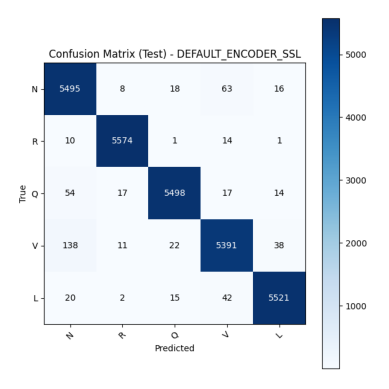

Finished. Outputs saved inside ENCODER_SSL_BEATS/Default_ENCODER_SSL folder.


In [10]:
print('\n' + '='*80)
print('Starting DEFAULT ENCODER+SSL 5-Fold training...')
print('='*80)

default_cfg = DEFAULT_CONFIG
folds_default = run_5fold_training(default_cfg, default_run_name='default_encoder_ssl')
summarize_folds(folds_default, 'DEFAULT_ENCODER_SSL')

all_preds = []
all_trues = []
for f, d in folds_default.items():
    all_preds.extend(d['preds'])
    all_trues.extend(d['trues'])

classification_report_and_cm(all_trues, all_preds, DEFAULT_CONFIG['dataset']['classes'], 'DEFAULT_ENCODER_SSL')

print('Finished. Outputs saved inside ENCODER_SSL_BEATS/Default_ENCODER_SSL folder.')

## 8.2. Hyperparameter Tuning ENCODER+SSL (Hyperparameter tuning + 5-Fold Training)

[I 2025-12-02 21:43:42,528] A new study created in memory with name: no-name-3dd3cada-a7fe-4660-8b19-3a542c535734



Starting HYPERPARAMETER TUNING...


/tmp/ipykernel_20/1548249072.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/tmp/ipykernel_20/1548249072.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/tmp/ipykernel_20/1548249072.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  mlm_mask_ratio = trial.suggest_uniform('mlm_mask_ratio', 0.10, 0.25)
/tmp/ipykernel_20/1548249072.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This featu

Best trial: {'lr': 0.00023788732191856274, 'weight_decay': 0.005027046261463704, 'hidden_dim': 192, 'n_heads': 2, 'mlm_mask_ratio': 0.1483096404767965, 'ssl_weight': 0.712983805291341, 'temperature': 0.10381824717196188}
Running 5-fold with HPO best config...

Starting fold 1 - Encoder+SSL Training

--- Phase 1: SSL Pretraining (2 epochs) ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Pretrain Epoch 1/2: contrastive=0.5912 recon=0.0461
Pretrain Epoch 2/2: contrastive=0.1797 recon=0.0413

--- Phase 2: Classification Fine-tuning (20 epochs) ---
Finetune Epoch 1/20: tr_loss=0.3066 tr_acc=0.8956 val_loss=0.1117 val_acc=0.9668


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 2/20: tr_loss=0.1146 tr_acc=0.9642 val_loss=0.0963 val_acc=0.9729


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 3/20: tr_loss=0.0915 tr_acc=0.9713 val_loss=0.0812 val_acc=0.9748


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 4/20: tr_loss=0.0807 tr_acc=0.9754 val_loss=0.0637 val_acc=0.9820


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 5/20: tr_loss=0.0753 tr_acc=0.9762 val_loss=0.0554 val_acc=0.9859


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 6/20: tr_loss=0.0594 tr_acc=0.9818 val_loss=0.0528 val_acc=0.9864


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 7/20: tr_loss=0.0569 tr_acc=0.9823 val_loss=0.0492 val_acc=0.9864


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 8/20: tr_loss=0.0501 tr_acc=0.9849 val_loss=0.0439 val_acc=0.9879


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 9/20: tr_loss=0.0502 tr_acc=0.9834 val_loss=0.0480 val_acc=0.9861


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 10/20: tr_loss=0.0454 tr_acc=0.9859 val_loss=0.0509 val_acc=0.9870


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 11/20: tr_loss=0.0436 tr_acc=0.9860 val_loss=0.0394 val_acc=0.9902


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 12/20: tr_loss=0.0419 tr_acc=0.9868 val_loss=0.0452 val_acc=0.9866


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 13/20: tr_loss=0.0410 tr_acc=0.9863 val_loss=0.0371 val_acc=0.9909


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 14/20: tr_loss=0.0376 tr_acc=0.9882 val_loss=0.0516 val_acc=0.9855


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 15/20: tr_loss=0.0322 tr_acc=0.9903 val_loss=0.0352 val_acc=0.9916


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 16/20: tr_loss=0.0369 tr_acc=0.9870 val_loss=0.0438 val_acc=0.9891


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 17/20: tr_loss=0.0311 tr_acc=0.9904 val_loss=0.0342 val_acc=0.9905


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 18/20: tr_loss=0.0318 tr_acc=0.9898 val_loss=0.0409 val_acc=0.9875


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 19/20: tr_loss=0.0293 tr_acc=0.9908 val_loss=0.0542 val_acc=0.9879


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 20/20: tr_loss=0.0286 tr_acc=0.9907 val_loss=0.0388 val_acc=0.9886


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Starting fold 2 - Encoder+SSL Training

--- Phase 1: SSL Pretraining (2 epochs) ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Pretrain Epoch 1/2: contrastive=0.6138 recon=0.0575
Pretrain Epoch 2/2: contrastive=0.1644 recon=0.0535

--- Phase 2: Classification Fine-tuning (20 epochs) ---
Finetune Epoch 1/20: tr_loss=0.2967 tr_acc=0.8977 val_loss=0.1227 val_acc=0.9643


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 2/20: tr_loss=0.1115 tr_acc=0.9662 val_loss=0.0691 val_acc=0.9777


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 3/20: tr_loss=0.0898 tr_acc=0.9714 val_loss=0.0737 val_acc=0.9755


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 4/20: tr_loss=0.0747 tr_acc=0.9779 val_loss=0.0900 val_acc=0.9736


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 5/20: tr_loss=0.0680 tr_acc=0.9785 val_loss=0.1200 val_acc=0.9663


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 6/20: tr_loss=0.0573 tr_acc=0.9833 val_loss=0.0456 val_acc=0.9864


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 7/20: tr_loss=0.0520 tr_acc=0.9842 val_loss=0.0540 val_acc=0.9843


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 8/20: tr_loss=0.0534 tr_acc=0.9829 val_loss=0.0448 val_acc=0.9864


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 9/20: tr_loss=0.0489 tr_acc=0.9848 val_loss=0.0459 val_acc=0.9862


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 10/20: tr_loss=0.0458 tr_acc=0.9862 val_loss=0.0517 val_acc=0.9830


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 11/20: tr_loss=0.0426 tr_acc=0.9868 val_loss=0.0411 val_acc=0.9861


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 12/20: tr_loss=0.0373 tr_acc=0.9889 val_loss=0.0394 val_acc=0.9873


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 13/20: tr_loss=0.0376 tr_acc=0.9888 val_loss=0.0446 val_acc=0.9855


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 14/20: tr_loss=0.0355 tr_acc=0.9890 val_loss=0.0413 val_acc=0.9866


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 15/20: tr_loss=0.0369 tr_acc=0.9888 val_loss=0.0386 val_acc=0.9870


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 16/20: tr_loss=0.0327 tr_acc=0.9895 val_loss=0.0377 val_acc=0.9879


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 17/20: tr_loss=0.0354 tr_acc=0.9884 val_loss=0.0548 val_acc=0.9843


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 18/20: tr_loss=0.0327 tr_acc=0.9902 val_loss=0.0565 val_acc=0.9829


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 19/20: tr_loss=0.0295 tr_acc=0.9918 val_loss=0.0365 val_acc=0.9880


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 20/20: tr_loss=0.0310 tr_acc=0.9901 val_loss=0.0425 val_acc=0.9875


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Starting fold 3 - Encoder+SSL Training

--- Phase 1: SSL Pretraining (2 epochs) ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Pretrain Epoch 1/2: contrastive=0.6206 recon=0.0518
Pretrain Epoch 2/2: contrastive=0.1816 recon=0.0475

--- Phase 2: Classification Fine-tuning (20 epochs) ---
Finetune Epoch 1/20: tr_loss=0.3004 tr_acc=0.8970 val_loss=0.0920 val_acc=0.9700


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 2/20: tr_loss=0.1183 tr_acc=0.9639 val_loss=0.0874 val_acc=0.9746


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 3/20: tr_loss=0.0852 tr_acc=0.9746 val_loss=0.0770 val_acc=0.9771


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 4/20: tr_loss=0.0706 tr_acc=0.9775 val_loss=0.0673 val_acc=0.9809


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 5/20: tr_loss=0.0666 tr_acc=0.9791 val_loss=0.0650 val_acc=0.9812


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 6/20: tr_loss=0.0564 tr_acc=0.9830 val_loss=0.0581 val_acc=0.9829


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 7/20: tr_loss=0.0528 tr_acc=0.9836 val_loss=0.0539 val_acc=0.9866


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 8/20: tr_loss=0.0474 tr_acc=0.9854 val_loss=0.0490 val_acc=0.9857


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 9/20: tr_loss=0.0478 tr_acc=0.9850 val_loss=0.0519 val_acc=0.9852


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 10/20: tr_loss=0.0443 tr_acc=0.9866 val_loss=0.0485 val_acc=0.9857


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 11/20: tr_loss=0.0369 tr_acc=0.9875 val_loss=0.0566 val_acc=0.9855


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 12/20: tr_loss=0.0359 tr_acc=0.9894 val_loss=0.0464 val_acc=0.9864


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 13/20: tr_loss=0.0412 tr_acc=0.9871 val_loss=0.0489 val_acc=0.9864


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 14/20: tr_loss=0.0319 tr_acc=0.9904 val_loss=0.0747 val_acc=0.9786


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 15/20: tr_loss=0.0339 tr_acc=0.9893 val_loss=0.0439 val_acc=0.9882


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 16/20: tr_loss=0.0328 tr_acc=0.9896 val_loss=0.0437 val_acc=0.9889


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 17/20: tr_loss=0.0270 tr_acc=0.9914 val_loss=0.0481 val_acc=0.9871


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 18/20: tr_loss=0.0358 tr_acc=0.9892 val_loss=0.0531 val_acc=0.9868


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 19/20: tr_loss=0.0271 tr_acc=0.9918 val_loss=0.0551 val_acc=0.9855


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 20/20: tr_loss=0.0323 tr_acc=0.9904 val_loss=0.0470 val_acc=0.9877


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Starting fold 4 - Encoder+SSL Training

--- Phase 1: SSL Pretraining (2 epochs) ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Pretrain Epoch 1/2: contrastive=0.5941 recon=0.0557
Pretrain Epoch 2/2: contrastive=0.1794 recon=0.0509

--- Phase 2: Classification Fine-tuning (20 epochs) ---
Finetune Epoch 1/20: tr_loss=0.3116 tr_acc=0.8956 val_loss=0.1193 val_acc=0.9630


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 2/20: tr_loss=0.1219 tr_acc=0.9615 val_loss=0.1056 val_acc=0.9696


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 3/20: tr_loss=0.0856 tr_acc=0.9734 val_loss=0.0815 val_acc=0.9741


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 4/20: tr_loss=0.0770 tr_acc=0.9758 val_loss=0.0711 val_acc=0.9809


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 5/20: tr_loss=0.0616 tr_acc=0.9811 val_loss=0.0907 val_acc=0.9716


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 6/20: tr_loss=0.0655 tr_acc=0.9797 val_loss=0.0614 val_acc=0.9811


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 7/20: tr_loss=0.0530 tr_acc=0.9833 val_loss=0.0579 val_acc=0.9821


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 8/20: tr_loss=0.0555 tr_acc=0.9830 val_loss=0.0691 val_acc=0.9798


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 9/20: tr_loss=0.0482 tr_acc=0.9856 val_loss=0.0496 val_acc=0.9862


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 10/20: tr_loss=0.0433 tr_acc=0.9860 val_loss=0.0546 val_acc=0.9841


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 11/20: tr_loss=0.0469 tr_acc=0.9862 val_loss=0.0391 val_acc=0.9888


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 12/20: tr_loss=0.0391 tr_acc=0.9875 val_loss=0.0577 val_acc=0.9846


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 13/20: tr_loss=0.0428 tr_acc=0.9873 val_loss=0.0441 val_acc=0.9873


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 14/20: tr_loss=0.0389 tr_acc=0.9879 val_loss=0.0368 val_acc=0.9895


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 15/20: tr_loss=0.0357 tr_acc=0.9896 val_loss=0.0422 val_acc=0.9886


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 16/20: tr_loss=0.0323 tr_acc=0.9906 val_loss=0.0493 val_acc=0.9870


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 17/20: tr_loss=0.0304 tr_acc=0.9907 val_loss=0.0556 val_acc=0.9829


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 18/20: tr_loss=0.0377 tr_acc=0.9883 val_loss=0.0475 val_acc=0.9871


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 19/20: tr_loss=0.0334 tr_acc=0.9892 val_loss=0.0418 val_acc=0.9889


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 20/20: tr_loss=0.0309 tr_acc=0.9903 val_loss=0.0517 val_acc=0.9868


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Starting fold 5 - Encoder+SSL Training

--- Phase 1: SSL Pretraining (2 epochs) ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Pretrain Epoch 1/2: contrastive=0.6337 recon=0.0550
Pretrain Epoch 2/2: contrastive=0.1833 recon=0.0503

--- Phase 2: Classification Fine-tuning (20 epochs) ---
Finetune Epoch 1/20: tr_loss=0.3015 tr_acc=0.8986 val_loss=0.0946 val_acc=0.9723


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 2/20: tr_loss=0.1137 tr_acc=0.9647 val_loss=0.0891 val_acc=0.9723


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 3/20: tr_loss=0.0851 tr_acc=0.9731 val_loss=0.0851 val_acc=0.9739


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 4/20: tr_loss=0.0790 tr_acc=0.9758 val_loss=0.0684 val_acc=0.9788


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 5/20: tr_loss=0.0675 tr_acc=0.9790 val_loss=0.0721 val_acc=0.9770


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 6/20: tr_loss=0.0516 tr_acc=0.9842 val_loss=0.0611 val_acc=0.9846


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 7/20: tr_loss=0.0547 tr_acc=0.9831 val_loss=0.0506 val_acc=0.9855


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 8/20: tr_loss=0.0495 tr_acc=0.9856 val_loss=0.0563 val_acc=0.9821


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 9/20: tr_loss=0.0506 tr_acc=0.9843 val_loss=0.0558 val_acc=0.9836


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 10/20: tr_loss=0.0462 tr_acc=0.9854 val_loss=0.0583 val_acc=0.9825


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 11/20: tr_loss=0.0460 tr_acc=0.9857 val_loss=0.0513 val_acc=0.9836


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 12/20: tr_loss=0.0389 tr_acc=0.9877 val_loss=0.0483 val_acc=0.9839


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 13/20: tr_loss=0.0397 tr_acc=0.9877 val_loss=0.0509 val_acc=0.9862


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 14/20: tr_loss=0.0367 tr_acc=0.9896 val_loss=0.0558 val_acc=0.9852


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 15/20: tr_loss=0.0357 tr_acc=0.9888 val_loss=0.0510 val_acc=0.9875


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 16/20: tr_loss=0.0372 tr_acc=0.9888 val_loss=0.0540 val_acc=0.9850


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 17/20: tr_loss=0.0323 tr_acc=0.9905 val_loss=0.0415 val_acc=0.9877


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 18/20: tr_loss=0.0335 tr_acc=0.9895 val_loss=0.0416 val_acc=0.9884


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 19/20: tr_loss=0.0275 tr_acc=0.9916 val_loss=0.0414 val_acc=0.9889


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Finetune Epoch 20/20: tr_loss=0.0272 tr_acc=0.9912 val_loss=0.0434 val_acc=0.9879


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


HPO_ENCODER_SSL mean val acc: 0.9877 +/- 0.0006
--- Report: HPO_ENCODER_SSL ---
              precision    recall  f1-score   support

           N       0.98      0.98      0.98      5600
           R       0.99      1.00      1.00      5600
           Q       0.99      0.99      0.99      5600
           V       0.98      0.98      0.98      5600
           L       0.99      0.99      0.99      5600

    accuracy                           0.99     28000
   macro avg       0.99      0.99      0.99     28000
weighted avg       0.99      0.99      0.99     28000

Confusion Matrix:


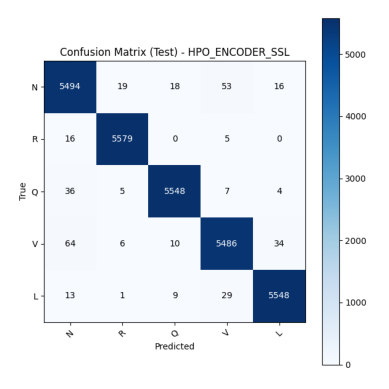

Finished. Outputs saved inside ENCODER_SSL_BEATS/HPO_ENCODER_SSL folder.

=== Comparison ===
DEFAULT mean acc: 0.9813928571428571
HPO mean acc: 0.9876785714285715

ENCODER+SSL TRAINING COMPLETED


In [11]:
if OPTUNA_AVAILABLE:
    print('\n' + '='*80)
    print('Starting HYPERPARAMETER TUNING...')
    print('='*80)
    hpo_cfg = json.loads(json.dumps(DEFAULT_CONFIG))
    hpo_cfg, study = run_hyperparam_search(hpo_cfg, n_trials=20, timeout=600)
    print('Running 5-fold with HPO best config...')
    folds_hpo = run_5fold_training(hpo_cfg, default_run_name='hpo_encoder_ssl')
    summarize_folds(folds_hpo, 'HPO_ENCODER_SSL')

    all_preds_hpo = []
    all_trues_hpo = []
    for f, d in folds_hpo.items():
        all_preds_hpo.extend(d['preds'])
        all_trues_hpo.extend(d['trues'])
    classification_report_and_cm(all_trues_hpo, all_preds_hpo, DEFAULT_CONFIG['dataset']['classes'], 'HPO_ENCODER_SSL')
    
    print('Finished. Outputs saved inside ENCODER_SSL_BEATS/HPO_ENCODER_SSL folder.')
    
    print('\n=== Comparison ===')
    print('DEFAULT mean acc:', np.mean([d['val_acc'] for d in folds_default.values()]))
    print('HPO mean acc:', np.mean([d['val_acc'] for d in folds_hpo.values()]))
else:
    print('Optuna not available. Skipping HPO run. To enable, install optuna.')


print("\n" + "="*80)
print("ENCODER+SSL TRAINING COMPLETED")
print("="*80)

In [12]:
print('\n=== Comparison ===')
print('DEFAULT mean acc:', np.mean([d['val_acc'] for d in folds_default.values()]))
print('HPO mean acc:', np.mean([d['val_acc'] for d in folds_hpo.values()]))


=== Comparison ===
DEFAULT mean acc: 0.9813928571428571
HPO mean acc: 0.9876785714285715


# 9. Evaluate

## 9.1. Evaluate Utils

In [13]:
def plot_training_history_per_fold(fold_results, model_name, save_prefix):
    """Plot training history (loss and accuracy) for each fold separately"""
    history_dir = OUTPUT_DIRS['default_history'] if save_prefix.lower() == 'default_encoder_ssl' else \
        OUTPUT_DIRS['hpo_history'] if save_prefix.lower() == 'hpo_encoder_ssl' else OUTPUT_DIRS['outputs']
    
    n_folds = len(fold_results)
    
    fig, axes = plt.subplots(2, n_folds, figsize=(5*n_folds, 10))
    if n_folds == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle(f'{model_name} - Training History per Fold\n\n', fontsize=16, y=0.95)
    
    for i, (fold_num, fold_data) in enumerate(fold_results.items()):
        history = fold_data['history']
        epochs = range(1, len(history['train_loss']) + 1)
        
        # Plot Loss
        axes[0, i].plot(epochs, history['train_loss'], 'b-', label='Train Loss', marker='o', markersize=3)
        axes[0, i].plot(epochs, history['val_loss'], 'red', label='Val Loss', marker='s', markersize=3)
        axes[0, i].set_title(f'Fold {fold_num} - Loss')
        axes[0, i].set_xlabel('Epoch')
        axes[0, i].set_ylabel('Loss')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)
        
        # Plot Accuracy
        axes[1, i].plot(epochs, history['train_acc'], 'b-', label='Train Acc', marker='o', markersize=3)
        axes[1, i].plot(epochs, history['val_acc'], 'red', label='Val Acc', marker='s', markersize=3)
        axes[1, i].set_title(f'Fold {fold_num} - Accuracy')
        axes[1, i].set_xlabel('Epoch')
        axes[1, i].set_ylabel('Accuracy')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)
        axes[1, i].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(f'{history_dir}/{save_prefix}_training_history_per_fold.png', dpi=300, bbox_inches='tight')
    plt.close()


def get_fold_predictions_detailed(fold_results, cfg, fold_num, dataset_type='train'):
    """Get predictions and true labels for a specific fold and dataset type"""
    device = cfg['training']['device']
    dataset = ECGBeatDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    
    X = list(range(len(dataset)))
    y = dataset.labels
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg['seed'])
    
    for current_fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        if current_fold + 1 == fold_num:
            if dataset_type == 'train':
                subset_idx = train_idx
            else:
                subset_idx = val_idx
                
            subset = Subset(dataset, subset_idx)
            loader = DataLoader(subset, batch_size=cfg['training']['batch_size'], 
                              shuffle=False, collate_fn=collate_ecg, 
                              num_workers=cfg['training']['num_workers'])
            
            sample_x, _ = dataset[subset_idx[0]]
            L = sample_x.shape[0]
            patch_size = cfg['model']['patch_size']
            num_patches = (L + patch_size - 1) // patch_size
            
            model = ENCODER_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
            model.load_state_dict(fold_results[fold_num]['model_state_dict'])
            
            _, _, preds, trues = validate(model, loader, device)
            return preds, trues
    
    return [], []


def plot_confusion_matrix_heatmap(y_true, y_pred, classes, title, save_path, cmap='Blues'):
    """Create confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'})
    
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    return cm


def generate_classification_reports_per_fold(fold_results, cfg, classes, model_name, save_prefix):
    """Generate classification reports for each fold (train and validation)"""
    reports = {
        'train': {},
        'val': {}
    }
    
    print(f"\n{'='*80}")
    print(f"{model_name} - CLASSIFICATION REPORTS PER FOLD")
    print('='*80)
    
    for fold_num in fold_results.keys():
        print(f"\n### FOLD {fold_num} ###")
        
        train_preds, train_trues = get_fold_predictions_detailed(fold_results, cfg, fold_num, 'train')
        if len(train_preds) > 0:
            train_report = classification_report(train_trues, train_preds, target_names=classes, output_dict=True)
            reports['train'][fold_num] = train_report
            
            print(f"\n--- FOLD {fold_num} TRAIN CLASSIFICATION REPORT ---")
            print(classification_report(train_trues, train_preds, target_names=classes))
        
        val_preds = fold_results[fold_num]['preds']
        val_trues = fold_results[fold_num]['trues']
        val_report = classification_report(val_trues, val_preds, target_names=classes, output_dict=True)
        reports['val'][fold_num] = val_report
        
        print(f"\n--- FOLD {fold_num} VALIDATION CLASSIFICATION REPORT ---")
        print(classification_report(val_trues, val_preds, target_names=classes))
    
    return reports


def generate_confusion_matrices_per_fold(fold_results, cfg, classes, model_name, save_prefix):
    """Generate confusion matrix for each fold (train and validation)"""
    print(f"\n{'='*80}")
    print(f"{model_name} - CONFUSION MATRIX PER FOLD")
    print('='*80)
    
    confusion_matrices = {
        'train': {},
        'val': {}
    }
    
    matrix_dir = OUTPUT_DIRS['default_matrix'] if save_prefix.lower() == 'default_encoder_ssl' else \
        OUTPUT_DIRS['hpo_matrix'] if save_prefix.lower() == 'hpo_encoder_ssl' else 'outputs'
    
    for fold_num in fold_results.keys():
        print(f"\n### FOLD {fold_num} CONFUSION MATRIX ###")
        
        train_preds, train_trues = get_fold_predictions_detailed(fold_results, cfg, fold_num, 'train')
        if len(train_preds) > 0:
            train_cm = plot_confusion_matrix_heatmap(
                train_trues, train_preds, classes,
                f'{model_name} - Fold {fold_num} Train Confusion Matrix',
                f'{matrix_dir}/{save_prefix}_fold{fold_num}_train_confusion_matrix.png',
                cmap='Blues'
            )
            confusion_matrices['train'][fold_num] = train_cm
            print(f"Fold {fold_num} Train Confusion Matrix saved")
            
            img = mpimg.imread(f'{matrix_dir}/{save_prefix}_fold{fold_num}_train_confusion_matrix.png')
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        
        val_preds = fold_results[fold_num]['preds']
        val_trues = fold_results[fold_num]['trues']
        val_cm = plot_confusion_matrix_heatmap(
            val_trues, val_preds, classes,
            f'{model_name} - Fold {fold_num} Validation Confusion Matrix',
            f'{matrix_dir}/{save_prefix}_fold{fold_num}_val_confusion_matrix.png',
            cmap='Blues'
        )
        confusion_matrices['val'][fold_num] = val_cm
        print(f"Fold {fold_num} Validation Confusion Matrix saved")
        
        img = mpimg.imread(f'{matrix_dir}/{save_prefix}_fold{fold_num}_val_confusion_matrix.png')
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    
    return confusion_matrices


def evaluate_test_set_for_fold(model_path, cfg, test_dirs, classes, fold_num, model_name, save_prefix):
    """Evaluate a specific fold model on test set"""
    device = cfg['training']['device']
    
    matrix_dir = OUTPUT_DIRS['default_matrix'] if save_prefix.lower() == 'default_encoder_ssl' else \
        OUTPUT_DIRS['hpo_matrix'] if save_prefix.lower() == 'hpo_encoder_ssl' else 'outputs'
    
    test_dataset = ECGBeatDataset(test_dirs, classes)
    test_loader = DataLoader(test_dataset, batch_size=cfg['training']['batch_size'], 
                            shuffle=False, collate_fn=collate_ecg, 
                            num_workers=cfg['training']['num_workers'])
    
    sample_x, _ = test_dataset[0]
    L = sample_x.shape[0]
    patch_size = cfg['model']['patch_size']
    num_patches = (L + patch_size - 1) // patch_size
    
    model = ENCODER_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    test_loss, test_acc, test_preds, test_trues = validate(model, test_loader, device)
    
    print(f"\n--- FOLD {fold_num} TEST CLASSIFICATION REPORT ---")
    test_report = classification_report(test_trues, test_preds, target_names=classes)
    print(test_report)
    
    test_cm = plot_confusion_matrix_heatmap(
        test_trues, test_preds, classes,
        f'{model_name} - Fold {fold_num} Test Confusion Matrix',
        f'{matrix_dir}/{save_prefix}_fold{fold_num}_test_confusion_matrix.png',
        cmap='Purples'
    )
    print(f"Fold {fold_num} Test Confusion Matrix saved")
    
    img = mpimg.imread(f'{matrix_dir}/{save_prefix}_fold{fold_num}_test_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    return {
        'loss': test_loss,
        'accuracy': test_acc,
        'predictions': test_preds,
        'true_labels': test_trues,
        'classification_report': classification_report(test_trues, test_preds, target_names=classes, output_dict=True),
        'confusion_matrix': test_cm
    }


def find_best_fold(fold_results):
    """Find best fold based on validation accuracy"""
    best_fold = None
    best_acc = 0
    
    for fold, data in fold_results.items():
        if data['val_acc'] > best_acc:
            best_acc = data['val_acc']
            best_fold = fold
    
    return best_fold, best_acc


def display_fold_metrics(fold_results, model_name):
    """Display metrics for each fold"""
    print(f"\n=== {model_name} - Metrics per Fold ===")
    print("Fold | Val Acc | Val Loss | Train Acc (Last) | Train Loss (Last)")
    print("-" * 70)
    
    for fold, data in fold_results.items():
        history = data['history']
        last_train_acc = history['train_acc'][-1] if history['train_acc'] else "N/A"
        last_train_loss = history['train_loss'][-1] if history['train_loss'] else "N/A"
        
        print(f"{fold:4d} | {data['val_acc']:7.4f} | {data['val_loss']:8.4f} | {last_train_acc:13.4f} | {last_train_loss:15.4f}")


def evaluate_model_on_test_set(model_path, cfg, test_dirs, classes):
    """Evaluate model on test set"""
    device = cfg['training']['device']
    
    test_dataset = ECGBeatDataset(test_dirs, classes)
    test_loader = DataLoader(test_dataset, batch_size=cfg['training']['batch_size'], 
                            shuffle=False, collate_fn=collate_ecg, 
                            num_workers=cfg['training']['num_workers'])
    
    sample_x, _ = test_dataset[0]
    L = sample_x.shape[0]
    patch_size = cfg['model']['patch_size']
    num_patches = (L + patch_size - 1) // patch_size
    
    model = ENCODER_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    test_loss, test_acc, test_preds, test_trues = validate(model, test_loader, device)
    
    return test_loss, test_acc, test_preds, test_trues


def get_train_predictions(fold_results, cfg):
    """Get predictions for training set from each fold"""
    device = cfg['training']['device']
    dataset = ECGBeatDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    
    all_train_preds = []
    all_train_trues = []
    
    for fold, fold_data in fold_results.items():
        X = list(range(len(dataset)))
        y = dataset.labels
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg['seed'])
        
        for current_fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            if current_fold + 1 == fold:
                train_subset = Subset(dataset, train_idx)
                train_loader = DataLoader(train_subset, batch_size=cfg['training']['batch_size'], 
                                        shuffle=False, collate_fn=collate_ecg, 
                                        num_workers=cfg['training']['num_workers'])
                
                sample_x, _ = dataset[train_idx[0]]
                L = sample_x.shape[0]
                patch_size = cfg['model']['patch_size']
                num_patches = (L + patch_size - 1) // patch_size
                
                model = ENCODER_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
                model.load_state_dict(fold_data['model_state_dict'])
                
                _, _, train_preds, train_trues = validate(model, train_loader, device)
                all_train_preds.extend(train_preds)
                all_train_trues.extend(train_trues)
                break
    
    return all_train_preds, all_train_trues


def compare_configurations(default_cfg, hpo_cfg=None, output_dir=None):
    """Compare default and HPO configurations"""
    print("\n=== Parameter Comparison ===")
    print("Parameter                | Default Config | Best HPO Config")
    print("-" * 60)
    
    data = []
    
    def add_row(param, default_value, hpo_value):
        data.append({
            'Parameter': param,
            'Default Config': default_value,
            'Best HPO Config': hpo_value if hpo_cfg else 'N/A'
        })
    
    add_row("Device", default_cfg['training']['device'], hpo_cfg['training']['device'] if hpo_cfg else None)
    add_row("Epoch", default_cfg['training']['num_epochs'], hpo_cfg['training']['num_epochs'] if hpo_cfg else None)
    add_row("Batch Size", default_cfg['training']['batch_size'], hpo_cfg['training']['batch_size'] if hpo_cfg else None)
    add_row("Learning Rate", default_cfg['training']['learning_rate'], hpo_cfg['training']['learning_rate'] if hpo_cfg else None)
    add_row("Weight Decay", default_cfg['training']['weight_decay'], hpo_cfg['training']['weight_decay'] if hpo_cfg else None)
    add_row("SSL Weight", default_cfg['training']['ssl_weight'], hpo_cfg['training']['ssl_weight'] if hpo_cfg else None)
    add_row("Hidden Dimension", default_cfg['model']['hidden_dim'], hpo_cfg['model']['hidden_dim'] if hpo_cfg else None)
    add_row("Number of Heads", default_cfg['model']['n_heads'], hpo_cfg['model']['n_heads'] if hpo_cfg else None)
    add_row("MLM Mask Ratio", default_cfg['model']['mlm_mask_ratio'], hpo_cfg['model']['mlm_mask_ratio'] if hpo_cfg else None)
    add_row("Temperature", default_cfg['model']['temperature'], hpo_cfg['model']['temperature'] if hpo_cfg else None)
    add_row("Dropout", default_cfg['model']['dropout'], hpo_cfg['model']['dropout'] if hpo_cfg else None)

    for row in data:
        print(f"{row['Parameter']:<24} | {str(row['Default Config']):14s} | {str(row['Best HPO Config']):15s}")

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, "parameter_comparison.xlsx")
        df = pd.DataFrame(data)
        df.to_excel(output_path, index=False)
        print(f"\n✅ Parameter comparison saved to: {output_path}")


def calculate_detailed_metrics(y_true, y_pred, classes):
    """Calculate detailed metrics: Accuracy, Sensitivity, Specificity, F1-Score"""
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None, labels=range(len(classes)))
    
    cm = confusion_matrix(y_true, y_pred)
    
    per_class_accuracy = []
    specificity = []
    
    for i in range(len(classes)):
        total = cm.sum()
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
 
        per_class_acc = (tp + tn) / total if total > 0 else 0
        per_class_accuracy.append(per_class_acc)
        
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)
    
    overall_accuracy = np.mean(per_class_accuracy)
    
    macro_sensitivity = np.mean(recall)
    macro_specificity = np.mean(specificity)
    macro_f1 = np.mean(f1)
    
    return {
        'per_class': {
            'accuracy': per_class_accuracy,
            'sensitivity': recall,
            'specificity': specificity,
            'f1_score': f1
        },
        'overall': {
            'accuracy': overall_accuracy,
            'sensitivity': macro_sensitivity,
            'specificity': macro_specificity,
            'f1_score': macro_f1
        }
    }


def get_test_metrics_for_best_fold(fold_results, cfg, classes, model_name, save_prefix):
    """Get test metrics for the best fold"""
    models_dir = OUTPUT_DIRS['default_models'] if save_prefix.lower() == 'default_encoder_ssl' else \
        OUTPUT_DIRS['hpo_models'] if save_prefix.lower() == 'hpo_encoder_ssl' else OUTPUT_DIRS['outputs']
    
    best_fold = None
    best_acc = 0
    for fold, data in fold_results.items():
        if data['val_acc'] > best_acc:
            best_acc = data['val_acc']
            best_fold = fold
    
    if best_fold is None:
        return None, None
        
    device = cfg['training']['device']
    test_dataset = ECGBeatDataset(cfg['dataset']['test_dirs'], classes)
    test_loader = DataLoader(test_dataset, batch_size=cfg['training']['batch_size'], 
                            shuffle=False, collate_fn=collate_ecg, 
                            num_workers=cfg['training']['num_workers'])
    
    sample_x, _ = test_dataset[0]
    L = sample_x.shape[0]
    patch_size = cfg['model']['patch_size']
    num_patches = (L + patch_size - 1) // patch_size
    
    model = ENCODER_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
    model_path = f'{models_dir}/{save_prefix}_fold{best_fold}.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    _, _, test_preds, test_trues = validate(model, test_loader, device)
    
    metrics = calculate_detailed_metrics(test_trues, test_preds, classes)
    
    results = []
    
    for i, class_name in enumerate(classes):
        results.append({
            'Best_Fold': best_fold,
            'Class': class_name,
            'Accuracy': f"{metrics['per_class']['accuracy'][i]:.4f}",
            'Sensitivity': f"{metrics['per_class']['sensitivity'][i]:.4f}",
            'Specificity': f"{metrics['per_class']['specificity'][i]:.4f}",
            'F1-Score': f"{metrics['per_class']['f1_score'][i]:.4f}"
        })
    
    results.append({
        'Best_Fold': best_fold,
        'Class': 'All',
        'Accuracy': f"{metrics['overall']['accuracy']:.4f}",
        'Sensitivity': f"{metrics['overall']['sensitivity']:.4f}",
        'Specificity': f"{metrics['overall']['specificity']:.4f}",
        'F1-Score': f"{metrics['overall']['f1_score']:.4f}"
    })
    
    return pd.DataFrame(results), best_fold


def create_detailed_metrics_table(fold_results, cfg, model_name, classes):
    """Create detailed metrics table for all folds"""
    results = []
    
    for fold_num in fold_results.keys():
        print(f"Processing {model_name} - Fold {fold_num}...")
        
        train_preds, train_trues = get_fold_predictions_detailed(fold_results, cfg, fold_num, 'train')
        
        if len(train_preds) > 0 and len(train_trues) > 0:
            metrics = calculate_detailed_metrics(train_trues, train_preds, classes)
            
            for i, class_name in enumerate(classes):
                results.append({
                    'Fold': f'Fold {fold_num}',
                    'Class': class_name,
                    'Accuracy': f"{metrics['per_class']['accuracy'][i]:.4f}",
                    'Sensitivity': f"{metrics['per_class']['sensitivity'][i]:.4f}",
                    'Specificity': f"{metrics['per_class']['specificity'][i]:.4f}",
                    'F1-Score': f"{metrics['per_class']['f1_score'][i]:.4f}"
                })
            
            results.append({
                'Fold': f'Fold {fold_num}',
                'Class': 'All',
                'Accuracy': f"{metrics['overall']['accuracy']:.4f}",
                'Sensitivity': f"{metrics['overall']['sensitivity']:.4f}",
                'Specificity': f"{metrics['overall']['specificity']:.4f}",
                'F1-Score': f"{metrics['overall']['f1_score']:.4f}"
            })
    
    all_train_preds = []
    all_train_trues = []
    
    for fold_num in fold_results.keys():
        train_preds, train_trues = get_fold_predictions_detailed(fold_results, cfg, fold_num, 'train')
        all_train_preds.extend(train_preds)
        all_train_trues.extend(train_trues)
    
    if len(all_train_preds) > 0:
        overall_metrics = calculate_detailed_metrics(all_train_trues, all_train_preds, classes)
        results.append({
            'Fold': 'Across 5 folds',
            'Class': 'All',
            'Accuracy': f"{overall_metrics['overall']['accuracy']:.4f}",
            'Sensitivity': f"{overall_metrics['overall']['sensitivity']:.4f}",
            'Specificity': f"{overall_metrics['overall']['specificity']:.4f}",
            'F1-Score': f"{overall_metrics['overall']['f1_score']:.4f}"
        })
    
    return pd.DataFrame(results)


def display_metrics_table(df, title):
    """Display metrics table in a formatted way"""
    print(f"\n{'='*80}")
    print(f"{title:^80}")
    print('='*80)
    
    current_fold = None
    for _, row in df.iterrows():
        if row['Fold'] != current_fold:
            if current_fold is not None:
                print('-'*80)
            current_fold = row['Fold']
            print(f"\n{row['Fold']:<15} {row['Class']:<5} {row['Accuracy']:<10} {row['Sensitivity']:<12} {row['Specificity']:<12} {row['F1-Score']:<10}")
        else:
            print(f"{'':15} {row['Class']:<5} {row['Accuracy']:<10} {row['Sensitivity']:<12} {row['Specificity']:<12} {row['F1-Score']:<10}")


def save_metrics_to_excel_enhanced(df_default, df_hpo=None, fold_results_default=None, fold_results_hpo=None, 
                                   default_cfg=None, hpo_cfg=None, classes=None, 
                                   filename=f'{OUTPUT_DIRS["outputs"]}/detailed_metrics_comparison.xlsx'):
    """Save metrics tables to Excel file with test results for best folds"""
    
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        df_default.to_excel(writer, sheet_name='Default_Train_ENCODER_SSL', index=False)
        if df_hpo is not None:
            df_hpo.to_excel(writer, sheet_name='Tuning_Train_ENCODER_SSL', index=False)
        
        if fold_results_default is not None and default_cfg is not None and classes is not None:
            print("Generating Default_Test_ENCODER_SSL sheet...")
            df_default_test, best_fold_default = get_test_metrics_for_best_fold(
                fold_results_default, default_cfg, classes, "Default ENCODER+SSL", "default_encoder_ssl"
            )
            if df_default_test is not None:
                df_default_test.to_excel(writer, sheet_name='Default_Test_ENCODER_SSL', index=False)
                print(f"Default_Test_ENCODER_SSL sheet created for best fold {best_fold_default}.")
        
        if fold_results_hpo is not None and hpo_cfg is not None and classes is not None:
            print("Generating Tuning_Test_ENCODER_SSL sheet...")
            df_hpo_test, best_fold_hpo = get_test_metrics_for_best_fold(
                fold_results_hpo, hpo_cfg, classes, "HPO ENCODER+SSL", "hpo_encoder_ssl"
            )
            if df_hpo_test is not None:
                df_hpo_test.to_excel(writer, sheet_name='Tuning_Test_ENCODER_SSL', index=False)
                print(f"Tuning_Test_ENCODER_SSL sheet created for best fold {best_fold_hpo}.")
    
    print(f"Enhanced metrics saved to {filename}")

## 9.2. Best Fold - Default ENCODER+SSL & HPO ENCODER+SSL

In [14]:
best_fold_default, best_acc_default = find_best_fold(folds_default)
print(f"\n=> Best Fold (Default ENCODER+SSL): Fold {best_fold_default} with accuracy {best_acc_default:.4f}")

display_fold_metrics(folds_default, "DEFAULT ENCODER+SSL")

best_model_path = f'{OUTPUT_DIRS["default_models"]}/default_encoder_ssl_fold{best_fold_default}.pth'
test_loss_default, test_acc_default, test_preds_default, test_trues_default = evaluate_model_on_test_set(
    best_model_path, default_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
)

print(f"\nTest Accuracy Default ENCODER+SSL: {test_acc_default:.4f}")
print(f"Test Loss Default ENCODER+SSL: {test_loss_default:.4f}")

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    best_fold_hpo, best_acc_hpo = find_best_fold(folds_hpo)
    print(f"\n=> Best Fold (HPO ENCODER+SSL): Fold {best_fold_hpo} with accuracy {best_acc_hpo:.4f}")
    
    display_fold_metrics(folds_hpo, "HPO ENCODER+SSL")

    best_model_path_hpo = f'{OUTPUT_DIRS["hpo_models"]}/hpo_encoder_ssl_fold{best_fold_hpo}.pth'
    test_loss_hpo, test_acc_hpo, test_preds_hpo, test_trues_hpo = evaluate_model_on_test_set(
        best_model_path_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
    )
    
    print(f"\nTest Accuracy HPO ENCODER+SSL: {test_acc_hpo:.4f}")
    print(f"Test Loss HPO ENCODER+SSL: {test_loss_hpo:.4f}")
    
    print(f"\n\n=== IMPROVEMENT SUMMARY ===")
    print(f"Improvement: {((best_acc_hpo - best_acc_default) / best_acc_default * 100):+.2f}% (validation)")
    print(f"Improvement: {((test_acc_hpo - test_acc_default) / test_acc_default * 100):+.2f}% (test)\n")


=> Best Fold (Default ENCODER+SSL): Fold 1 with accuracy 0.9873

=== DEFAULT ENCODER+SSL - Metrics per Fold ===
Fold | Val Acc | Val Loss | Train Acc (Last) | Train Loss (Last)
----------------------------------------------------------------------
   1 |  0.9873 |   0.0554 |        0.9813 |          0.0612
   2 |  0.9811 |   0.0633 |        0.9766 |          0.0775
   3 |  0.9807 |   0.0870 |        0.9799 |          0.0710
   4 |  0.9818 |   0.0636 |        0.9730 |          0.0918
   5 |  0.9761 |   0.0774 |        0.9812 |          0.0692


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Test Accuracy Default ENCODER+SSL: 0.9854
Test Loss Default ENCODER+SSL: 0.0544

=> Best Fold (HPO ENCODER+SSL): Fold 1 with accuracy 0.9886

=== HPO ENCODER+SSL - Metrics per Fold ===
Fold | Val Acc | Val Loss | Train Acc (Last) | Train Loss (Last)
----------------------------------------------------------------------
   1 |  0.9886 |   0.0388 |        0.9907 |          0.0286
   2 |  0.9875 |   0.0425 |        0.9901 |          0.0310
   3 |  0.9877 |   0.0470 |        0.9904 |          0.0323
   4 |  0.9868 |   0.0517 |        0.9903 |          0.0309
   5 |  0.9879 |   0.0434 |        0.9912 |          0.0272


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Test Accuracy HPO ENCODER+SSL: 0.9861
Test Loss HPO ENCODER+SSL: 0.0490


=== IMPROVEMENT SUMMARY ===
Improvement: +0.13% (validation)
Improvement: +0.07% (test)



## 9.3. Training History per Fold - Default ENCODER+SSL & HPO ENCODER+SSL


Generating training history Default ENCODER+SSL plots per fold...


Default ENCODER+SSL - Training History per Fold:


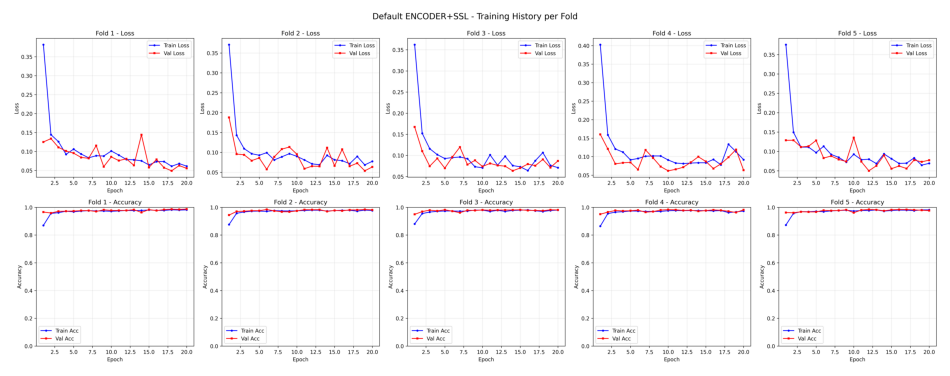

Generating training history HPO ENCODER+SSL plots per fold...


HPO ENCODER+SSL - Training History per Fold:


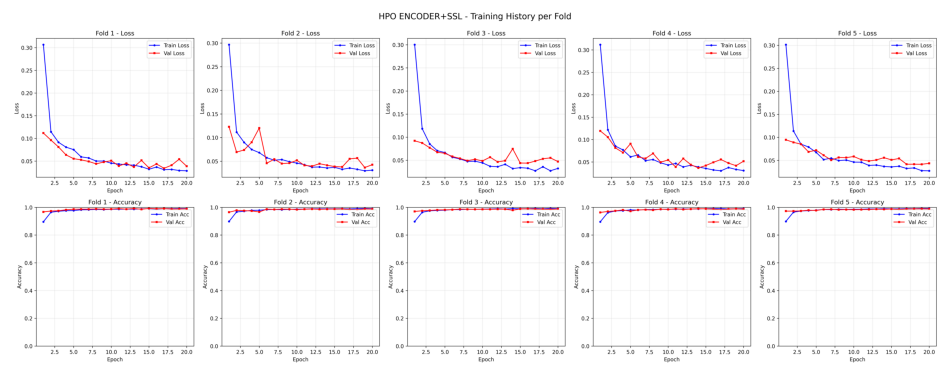

In [15]:
print("\nGenerating training history Default ENCODER+SSL plots per fold...")
plot_training_history_per_fold(folds_default, 'Default ENCODER+SSL', 'default_encoder_ssl')

print("\n\nDefault ENCODER+SSL - Training History per Fold:")
img = mpimg.imread(f'{OUTPUT_DIRS["default_history"]}/default_encoder_ssl_training_history_per_fold.png')
plt.figure(figsize=(12, 12)) 
plt.imshow(img)
plt.axis('off')
plt.show()

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("Generating training history HPO ENCODER+SSL plots per fold...")
    plot_training_history_per_fold(folds_hpo, 'HPO ENCODER+SSL', 'hpo_encoder_ssl')

    print("\n\nHPO ENCODER+SSL - Training History per Fold:")
    img = mpimg.imread(f'{OUTPUT_DIRS["hpo_history"]}/hpo_encoder_ssl_training_history_per_fold.png')
    plt.figure(figsize=(12, 12)) 
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 9.4. Classification Report per Fold - Default ENCODER+SSL & HPO ENCODER+SSL

In [16]:
print("\nGenerating classification Default ENCODER+SSL reports per fold...")
reports_default = generate_classification_reports_per_fold(
    folds_default, default_cfg, DEFAULT_CONFIG['dataset']['classes'], 'Default ENCODER+SSL', 'default_encoder_ssl'
)

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("\nGenerating classification HPO ENCODER+SSL reports per fold...")
    reports_hpo = generate_classification_reports_per_fold(
        folds_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['classes'], 'HPO ENCODER+SSL', 'hpo_encoder_ssl'
    )


Generating classification Default ENCODER+SSL reports per fold...

Default ENCODER+SSL - CLASSIFICATION REPORTS PER FOLD

### FOLD 1 ###


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- FOLD 1 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.99      0.97      0.98      4480
           R       1.00      0.99      1.00      4480
           Q       0.99      1.00      1.00      4480
           V       0.97      0.99      0.98      4480
           L       0.99      0.99      0.99      4480

    accuracy                           0.99     22400
   macro avg       0.99      0.99      0.99     22400
weighted avg       0.99      0.99      0.99     22400


--- FOLD 1 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.99      0.97      0.98      1120
           R       1.00      1.00      1.00      1120
           Q       0.99      0.99      0.99      1120
           V       0.97      0.98      0.98      1120
           L       0.99      0.99      0.99      1120

    accuracy                           0.99      5600
   macro avg       0.99      0.99     

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- FOLD 2 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.96      0.99      0.97      4480
           R       1.00      1.00      1.00      4480
           Q       1.00      0.99      0.99      4480
           V       0.98      0.97      0.97      4480
           L       0.99      0.99      0.99      4480

    accuracy                           0.99     22400
   macro avg       0.99      0.99      0.99     22400
weighted avg       0.99      0.99      0.99     22400


--- FOLD 2 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.95      0.98      0.97      1120
           R       1.00      0.99      1.00      1120
           Q       1.00      0.98      0.99      1120
           V       0.98      0.96      0.97      1120
           L       0.98      0.98      0.98      1120

    accuracy                           0.98      5600
   macro avg       0.98      0.98     

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- FOLD 3 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.99      0.97      0.98      4480
           R       0.99      1.00      1.00      4480
           Q       0.98      1.00      0.99      4480
           V       0.97      0.97      0.97      4480
           L       0.99      0.99      0.99      4480

    accuracy                           0.99     22400
   macro avg       0.99      0.99      0.99     22400
weighted avg       0.99      0.99      0.99     22400


--- FOLD 3 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.98      0.97      0.98      1120
           R       0.99      1.00      0.99      1120
           Q       0.97      0.99      0.98      1120
           V       0.97      0.97      0.97      1120
           L       0.99      0.98      0.98      1120

    accuracy                           0.98      5600
   macro avg       0.98      0.98     

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- FOLD 4 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.95      0.99      0.97      4480
           R       0.99      1.00      1.00      4480
           Q       0.99      0.99      0.99      4480
           V       0.98      0.95      0.97      4480
           L       0.99      0.98      0.99      4480

    accuracy                           0.98     22400
   macro avg       0.98      0.98      0.98     22400
weighted avg       0.98      0.98      0.98     22400


--- FOLD 4 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.96      0.99      0.97      1120
           R       0.99      0.99      0.99      1120
           Q       0.99      0.99      0.99      1120
           V       0.98      0.95      0.97      1120
           L       0.99      0.98      0.98      1120

    accuracy                           0.98      5600
   macro avg       0.98      0.98     

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- FOLD 5 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.93      0.99      0.96      4480
           R       0.98      0.99      0.99      4480
           Q       1.00      0.95      0.98      4480
           V       0.98      0.95      0.97      4480
           L       0.99      0.99      0.99      4480

    accuracy                           0.98     22400
   macro avg       0.98      0.98      0.98     22400
weighted avg       0.98      0.98      0.98     22400


--- FOLD 5 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.93      0.99      0.96      1120
           R       0.98      1.00      0.99      1120
           Q       1.00      0.95      0.98      1120
           V       0.99      0.95      0.97      1120
           L       0.99      0.99      0.99      1120

    accuracy                           0.98      5600
   macro avg       0.98      0.98     

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- FOLD 1 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.99      0.99      0.99      4480
           R       1.00      1.00      1.00      4480
           Q       0.99      1.00      1.00      4480
           V       1.00      0.98      0.99      4480
           L       0.99      1.00      0.99      4480

    accuracy                           0.99     22400
   macro avg       0.99      0.99      0.99     22400
weighted avg       0.99      0.99      0.99     22400


--- FOLD 1 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.99      0.98      0.98      1120
           R       1.00      1.00      1.00      1120
           Q       0.98      0.99      0.99      1120
           V       0.99      0.98      0.98      1120
           L       0.99      0.99      0.99      1120

    accuracy                           0.99      5600
   macro avg       0.99      0.99     

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- FOLD 2 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       1.00      0.98      0.99      4480
           R       0.99      1.00      0.99      4480
           Q       1.00      1.00      1.00      4480
           V       0.99      0.99      0.99      4480
           L       0.99      1.00      1.00      4480

    accuracy                           0.99     22400
   macro avg       0.99      0.99      0.99     22400
weighted avg       0.99      0.99      0.99     22400


--- FOLD 2 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.99      0.97      0.98      1120
           R       0.99      1.00      0.99      1120
           Q       1.00      1.00      1.00      1120
           V       0.98      0.98      0.98      1120
           L       0.98      0.99      0.99      1120

    accuracy                           0.99      5600
   macro avg       0.99      0.99     

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- FOLD 3 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.99      1.00      0.99      4480
           R       1.00      1.00      1.00      4480
           Q       1.00      1.00      1.00      4480
           V       0.98      0.99      0.99      4480
           L       1.00      0.99      0.99      4480

    accuracy                           0.99     22400
   macro avg       0.99      0.99      0.99     22400
weighted avg       0.99      0.99      0.99     22400


--- FOLD 3 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.97      0.99      0.98      1120
           R       1.00      1.00      1.00      1120
           Q       0.99      0.99      0.99      1120
           V       0.98      0.98      0.98      1120
           L       1.00      0.98      0.99      1120

    accuracy                           0.99      5600
   macro avg       0.99      0.99     

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- FOLD 4 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.98      1.00      0.99      4480
           R       1.00      1.00      1.00      4480
           Q       1.00      0.98      0.99      4480
           V       0.99      0.99      0.99      4480
           L       0.99      1.00      0.99      4480

    accuracy                           0.99     22400
   macro avg       0.99      0.99      0.99     22400
weighted avg       0.99      0.99      0.99     22400


--- FOLD 4 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.96      0.99      0.98      1120
           R       0.99      1.00      0.99      1120
           Q       1.00      0.98      0.99      1120
           V       0.99      0.98      0.98      1120
           L       1.00      0.99      0.99      1120

    accuracy                           0.99      5600
   macro avg       0.99      0.99     

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- FOLD 5 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.99      1.00      1.00      4480
           R       1.00      1.00      1.00      4480
           Q       1.00      1.00      1.00      4480
           V       0.99      0.99      0.99      4480
           L       1.00      1.00      1.00      4480

    accuracy                           1.00     22400
   macro avg       1.00      1.00      1.00     22400
weighted avg       1.00      1.00      1.00     22400


--- FOLD 5 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.98      0.97      0.98      1120
           R       0.99      0.99      0.99      1120
           Q       0.99      1.00      1.00      1120
           V       0.98      0.98      0.98      1120
           L       0.99      0.99      0.99      1120

    accuracy                           0.99      5600
   macro avg       0.99      0.99     

## 9.5.  Confusion Matrix per Fold - Default ENCODER+SSL & HPO ENCODER+SSL


Generating Confusion Matrix Default ENCODER+SSL per fold...

Default ENCODER+SSL - CONFUSION MATRIX PER FOLD

### FOLD 1 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Fold 1 Train Confusion Matrix saved


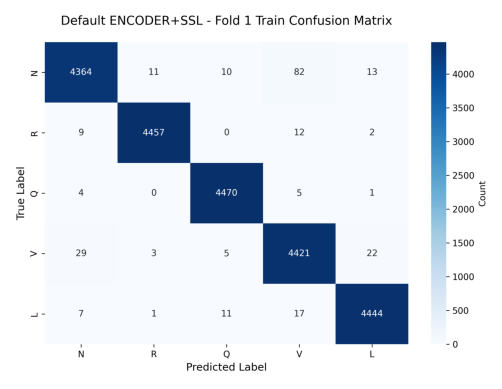

Fold 1 Validation Confusion Matrix saved


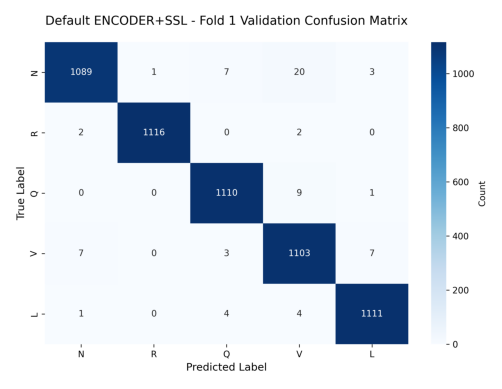


### FOLD 2 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Fold 2 Train Confusion Matrix saved


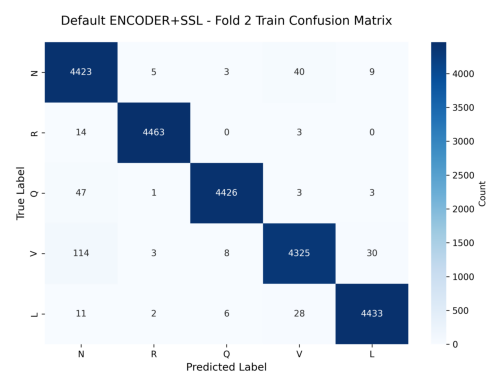

Fold 2 Validation Confusion Matrix saved


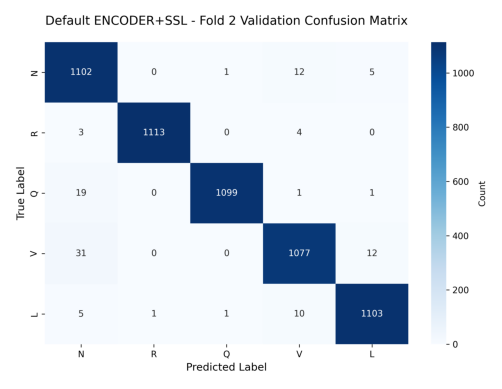


### FOLD 3 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Fold 3 Train Confusion Matrix saved


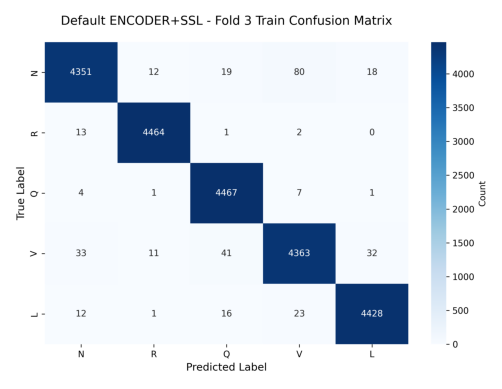

Fold 3 Validation Confusion Matrix saved


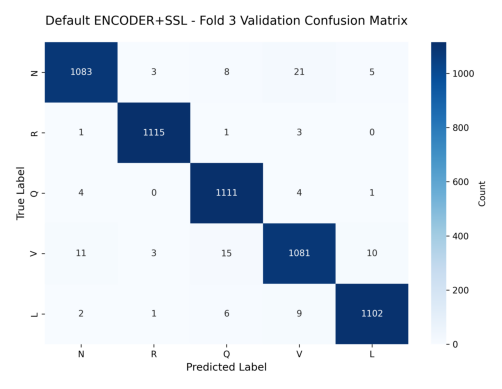


### FOLD 4 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Fold 4 Train Confusion Matrix saved


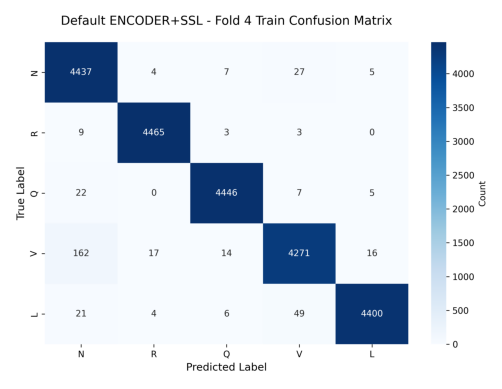

Fold 4 Validation Confusion Matrix saved


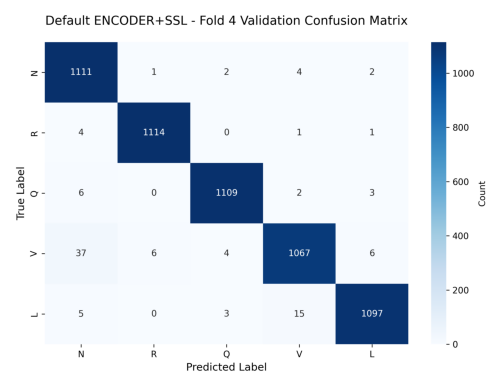


### FOLD 5 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Fold 5 Train Confusion Matrix saved


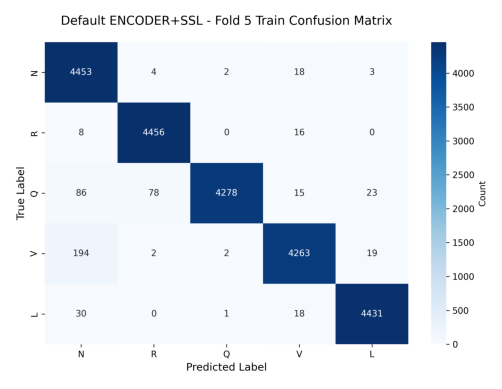

Fold 5 Validation Confusion Matrix saved


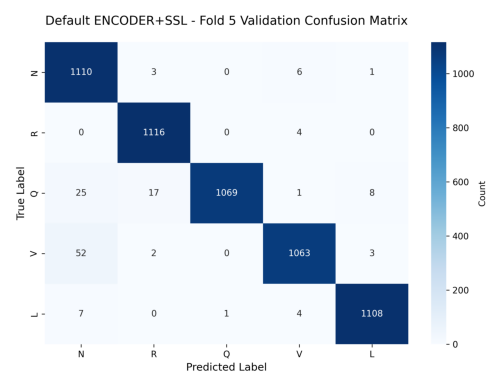


Generating Confusion Matrix HPO ENCODER+SSL per fold...

HPO ENCODER+SSL - CONFUSION MATRIX PER FOLD

### FOLD 1 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Fold 1 Train Confusion Matrix saved


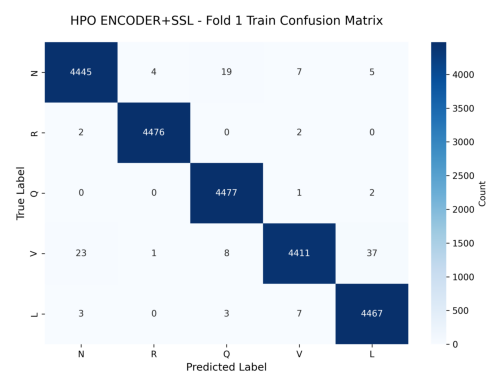

Fold 1 Validation Confusion Matrix saved


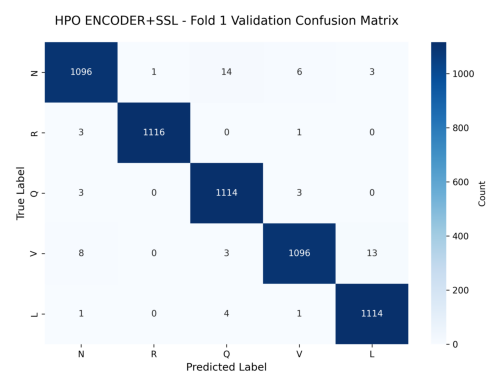


### FOLD 2 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Fold 2 Train Confusion Matrix saved


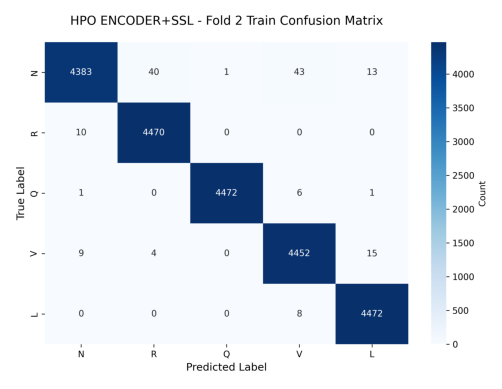

Fold 2 Validation Confusion Matrix saved


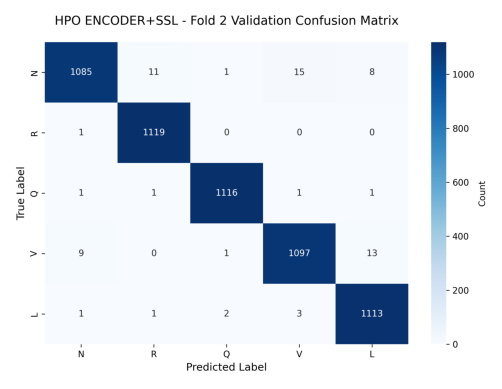


### FOLD 3 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Fold 3 Train Confusion Matrix saved


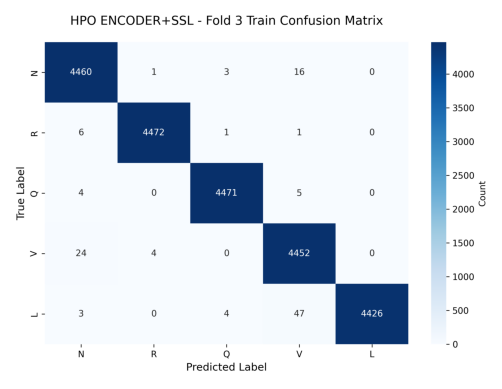

Fold 3 Validation Confusion Matrix saved


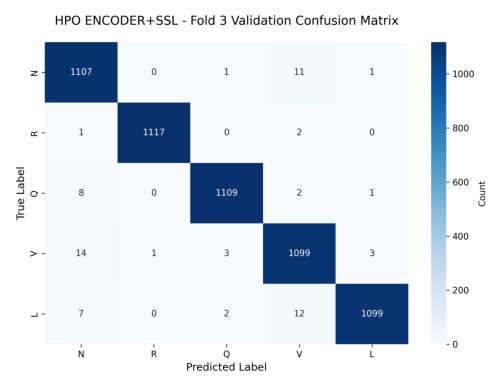


### FOLD 4 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Fold 4 Train Confusion Matrix saved


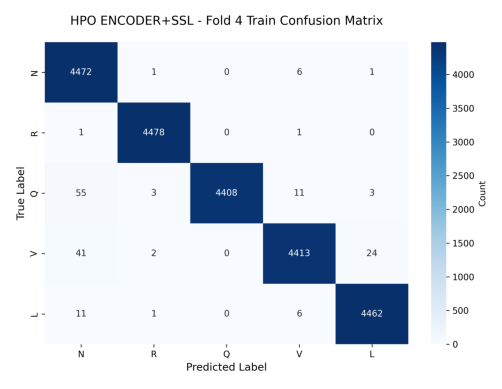

Fold 4 Validation Confusion Matrix saved


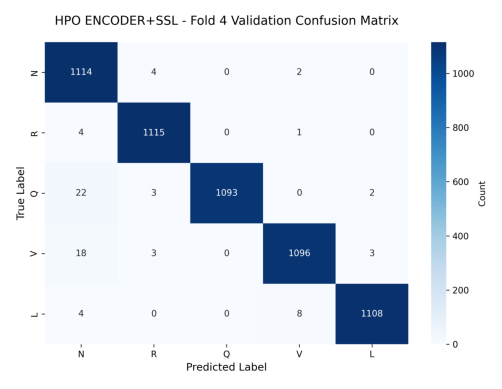


### FOLD 5 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Fold 5 Train Confusion Matrix saved


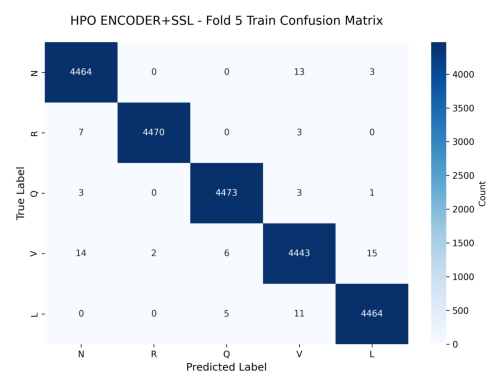

Fold 5 Validation Confusion Matrix saved


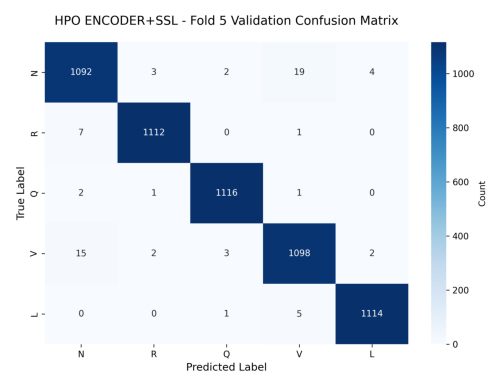

In [17]:
print("\nGenerating Confusion Matrix Default ENCODER+SSL per fold...")
cm_default = generate_confusion_matrices_per_fold(
    folds_default, default_cfg, DEFAULT_CONFIG['dataset']['classes'], 'Default ENCODER+SSL', 'default_encoder_ssl'
)

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("\nGenerating Confusion Matrix HPO ENCODER+SSL per fold...")
    cm_hpo = generate_confusion_matrices_per_fold(
        folds_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['classes'], 'HPO ENCODER+SSL', 'hpo_encoder_ssl'
    )

## 9.6. Best Fold Default ENCODER+SSL & HPO ENCODER+SSL - Train & Test Evaluation

### 9.6.1. Default ENCODER


Getting train predictions for Default ENCODER+SSL...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning:


--- Classification Report Train Default ENCODER+SSL ---
              precision    recall  f1-score   support

           N       0.96      0.98      0.97     22400
           R       0.99      1.00      0.99     22400
           Q       0.99      0.99      0.99     22400
           V       0.98      0.97      0.97     22400
           L       0.99      0.99      0.99     22400

    accuracy                           0.98    112000
   macro avg       0.98      0.98      0.98    112000
weighted avg       0.98      0.98      0.98    112000

Generating Confusion Matrix Train Default ENCODER+SSL...
Confusion Matrix Train Default ENCODER+SSL:



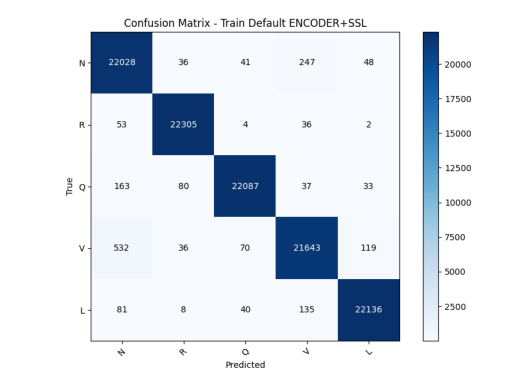


Evaluating Default ENCODER+SSL on test set...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy Default ENCODER+SSL: 0.9854
Test Loss Default ENCODER+SSL: 0.0544

--- Classification Report Test Default ENCODER+SSL ---
              precision    recall  f1-score   support

           N       0.99      0.96      0.97      1400
           R       0.99      0.99      0.99      1400
           Q       0.99      0.99      0.99      1400
           V       0.97      0.99      0.98      1400
           L       0.99      0.99      0.99      1400

    accuracy                           0.99      7000
   macro avg       0.99      0.99      0.99      7000
weighted avg       0.99      0.99      0.99      7000

Generating Confusion Matrix Test Default ENCODER+SSL...
Confusion Matrix Test Default ENCODER+SSL:



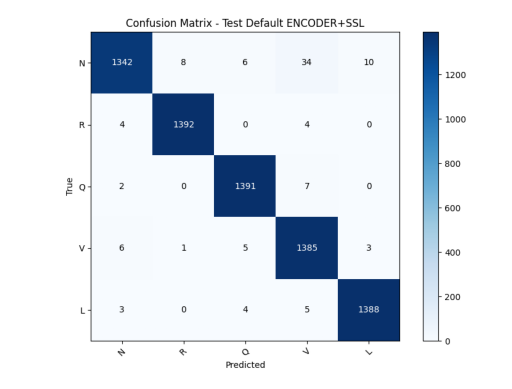

In [18]:
print("\nGetting train predictions for Default ENCODER+SSL...")
train_preds_default, train_trues_default = get_train_predictions(folds_default, default_cfg)

print("\n--- Classification Report Train Default ENCODER+SSL ---")
print(classification_report(train_trues_default, train_preds_default, target_names=DEFAULT_CONFIG['dataset']['classes']))

print("Generating Confusion Matrix Train Default ENCODER+SSL...")
cm_train_default = confusion_matrix(train_trues_default, train_preds_default)
print('Confusion Matrix Train Default ENCODER+SSL:\n')

plt.figure(figsize=(8,6))
plt.imshow(cm_train_default, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - Train Default ENCODER+SSL')
plt.colorbar()

for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
    for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        plt.text(j, i, str(cm_train_default[i, j]),
                 ha="center", va="center",
                 color="white" if cm_train_default[i, j] > cm_train_default.max()/2 else "black")

tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIRS["default_matrix"]}/train_default_encoder_ssl_confusion_matrix.png')
plt.close()

img = mpimg.imread(f'{OUTPUT_DIRS["default_matrix"]}/train_default_encoder_ssl_confusion_matrix.png')
plt.imshow(img)
plt.axis('off')
plt.show()

print("\nEvaluating Default ENCODER+SSL on test set...")
best_model_path = f'{OUTPUT_DIRS["default_models"]}/default_encoder_ssl_fold{best_fold_default}.pth'
test_loss_default, test_acc_default, test_preds_default, test_trues_default = evaluate_model_on_test_set(
    best_model_path, default_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
)

print(f"Test Accuracy Default ENCODER+SSL: {test_acc_default:.4f}")
print(f"Test Loss Default ENCODER+SSL: {test_loss_default:.4f}")

print("\n--- Classification Report Test Default ENCODER+SSL ---")
print(classification_report(test_trues_default, test_preds_default, target_names=DEFAULT_CONFIG['dataset']['classes']))

print("Generating Confusion Matrix Test Default ENCODER+SSL...")
cm_test_default = confusion_matrix(test_trues_default, test_preds_default)
print('Confusion Matrix Test Default ENCODER+SSL:\n')

plt.figure(figsize=(8,6))
plt.imshow(cm_test_default, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - Test Default ENCODER+SSL')
plt.colorbar()

for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
    for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        plt.text(j, i, str(cm_test_default[i, j]),
                 ha="center", va="center",
                 color="white" if cm_test_default[i, j] > cm_test_default.max()/2 else "black")

tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIRS["default_matrix"]}/test_default_encoder_ssl_confusion_matrix.png')
plt.close()

img = mpimg.imread(f'{OUTPUT_DIRS["default_matrix"]}/test_default_encoder_ssl_confusion_matrix.png')
plt.imshow(img)
plt.axis('off')
plt.show()

### 9.6.2. HPO ENCODER


Getting train predictions for HPO ENCODER+SSL...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning:


--- Classification Report Train HPO ENCODER+SSL ---
              precision    recall  f1-score   support

           N       0.99      0.99      0.99     22400
           R       1.00      1.00      1.00     22400
           Q       1.00      1.00      1.00     22400
           V       0.99      0.99      0.99     22400
           L       0.99      1.00      0.99     22400

    accuracy                           0.99    112000
   macro avg       0.99      0.99      0.99    112000
weighted avg       0.99      0.99      0.99    112000

Generating Confusion Matrix Train HPO ENCODER+SSL...
Confusion Matrix Train HPO ENCODER+SSL:



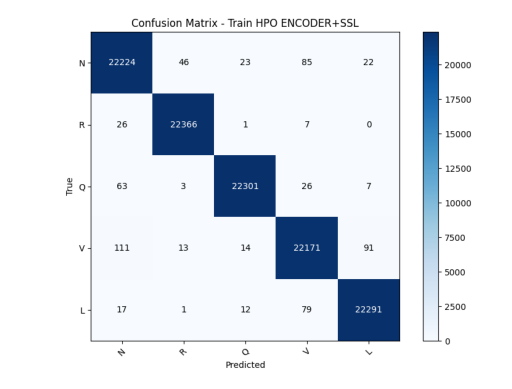


Evaluating HPO ENCODER+SSL on test set...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy HPO ENCODER+SSL: 0.9861
Test Loss HPO ENCODER+SSL: 0.0490

--- Classification Report Test HPO ENCODER+SSL ---
              precision    recall  f1-score   support

           N       0.98      0.98      0.98      1400
           R       1.00      1.00      1.00      1400
           Q       0.99      0.99      0.99      1400
           V       0.98      0.97      0.98      1400
           L       0.98      0.99      0.99      1400

    accuracy                           0.99      7000
   macro avg       0.99      0.99      0.99      7000
weighted avg       0.99      0.99      0.99      7000

Generating Confusion Matrix Test HPO ENCODER+SSL...
Confusion Matrix Test HPO ENCODER+SSL:



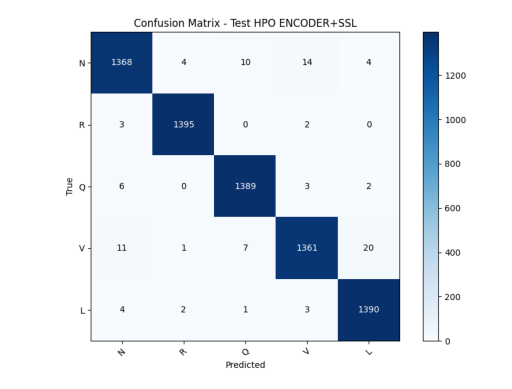

In [19]:
if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("\nGetting train predictions for HPO ENCODER+SSL...")
    train_preds_hpo, train_trues_hpo = get_train_predictions(folds_hpo, hpo_cfg)
    
    print("\n--- Classification Report Train HPO ENCODER+SSL ---")
    print(classification_report(train_trues_hpo, train_preds_hpo, target_names=DEFAULT_CONFIG['dataset']['classes']))
    
    print("Generating Confusion Matrix Train HPO ENCODER+SSL...")
    cm_train_hpo = confusion_matrix(train_trues_hpo, train_preds_hpo)
    print('Confusion Matrix Train HPO ENCODER+SSL:\n')
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm_train_hpo, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix - Train HPO ENCODER+SSL')
    plt.colorbar()
    
    for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
            plt.text(j, i, str(cm_train_hpo[i, j]),
                     ha="center", va="center",
                     color="white" if cm_train_hpo[i, j] > cm_train_hpo.max()/2 else "black")
    
    tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
    plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
    plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIRS["hpo_matrix"]}/train_hpo_encoder_ssl_confusion_matrix.png')
    plt.close()

    img = mpimg.imread(f'{OUTPUT_DIRS["hpo_matrix"]}/train_hpo_encoder_ssl_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    print("\nEvaluating HPO ENCODER+SSL on test set...")
    best_model_path_hpo = f'{OUTPUT_DIRS["hpo_models"]}/hpo_encoder_ssl_fold{best_fold_hpo}.pth'
    test_loss_hpo, test_acc_hpo, test_preds_hpo, test_trues_hpo = evaluate_model_on_test_set(
        best_model_path_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
    )
    
    print(f"Test Accuracy HPO ENCODER+SSL: {test_acc_hpo:.4f}")
    print(f"Test Loss HPO ENCODER+SSL: {test_loss_hpo:.4f}")
    
    print("\n--- Classification Report Test HPO ENCODER+SSL ---")
    print(classification_report(test_trues_hpo, test_preds_hpo, target_names=DEFAULT_CONFIG['dataset']['classes']))
    
    print("Generating Confusion Matrix Test HPO ENCODER+SSL...")
    cm_test_hpo = confusion_matrix(test_trues_hpo, test_preds_hpo)
    print('Confusion Matrix Test HPO ENCODER+SSL:\n')
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm_test_hpo, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix - Test HPO ENCODER+SSL')
    plt.colorbar()
    
    for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
            plt.text(j, i, str(cm_test_hpo[i, j]),
                     ha="center", va="center",
                     color="white" if cm_test_hpo[i, j] > cm_test_hpo.max()/2 else "black")
    
    tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
    plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
    plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIRS["hpo_matrix"]}/test_hpo_encoder_ssl_confusion_matrix.png')
    plt.close()

    img = mpimg.imread(f'{OUTPUT_DIRS["hpo_matrix"]}/test_hpo_encoder_ssl_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 9.7. Default ENCODER+SSL & HPO ENCODER+SSL - Parameter Comparison

In [20]:
if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    compare_configurations(default_cfg, hpo_cfg, output_dir=OUTPUT_DIRS['outputs'])
else:
    compare_configurations(default_cfg, None, output_dir=OUTPUT_DIRS['outputs'])


=== Parameter Comparison ===
Parameter                | Default Config | Best HPO Config
------------------------------------------------------------
Device                   | cuda           | cuda           
Epoch                    | 20             | 20             
Batch Size               | 64             | 64             
Learning Rate            | 0.001          | 0.00023788732191856274
Weight Decay             | 0.0001         | 0.005027046261463704
SSL Weight               | 0.5            | 0.712983805291341
Hidden Dimension         | 128            | 192            
Number of Heads          | 4              | 2              
MLM Mask Ratio           | 0.15           | 0.1483096404767965
Temperature              | 0.07           | 0.10381824717196188
Dropout                  | 0.1            | 0.1            

✅ Parameter comparison saved to: ENCODER_SSL_BEATS/parameter_comparison.xlsx


## 9.8. Export Detailed Metrics Table to Excel

In [21]:
print("\n" + "="*80)
print("GENERATING DETAILED METRICS TABLES")
print("="*80)

print("\nGenerating detailed metrics table for Default ENCODER+SSL...")
df_default_metrics = create_detailed_metrics_table(folds_default, default_cfg, "Default ENCODER+SSL", DEFAULT_CONFIG['dataset']['classes'])
display_metrics_table(df_default_metrics, "Default Train ENCODER+SSL Metrics")

df_hpo_metrics = None
fold_results_hpo_for_excel = None
hpo_cfg_for_excel = None

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("\nGenerating detailed metrics table for HPO ENCODER+SSL...")
    df_hpo_metrics = create_detailed_metrics_table(folds_hpo, hpo_cfg, "HPO ENCODER+SSL", DEFAULT_CONFIG['dataset']['classes'])
    display_metrics_table(df_hpo_metrics, "Tuning Train ENCODER+SSL Metrics")
    fold_results_hpo_for_excel = folds_hpo
    hpo_cfg_for_excel = hpo_cfg

print("\nSaving enhanced Excel file with test results for best folds...")
save_metrics_to_excel_enhanced(
    df_default_metrics, 
    df_hpo_metrics, 
    fold_results_default=folds_default,
    fold_results_hpo=fold_results_hpo_for_excel,
    default_cfg=default_cfg,
    hpo_cfg=hpo_cfg_for_excel,
    classes=DEFAULT_CONFIG['dataset']['classes']
)

if df_hpo_metrics is not None:
    print(f"\n{'='*160}")
    print(f"{'SIDE-BY-SIDE COMPARISON':^160}")
    print('='*160)
    print(f"{'Default Train ENCODER+SSL':<80} {'Tuning Train ENCODER+SSL':<80}")
    print('-'*160)
    print(f"{'Fold':<8} {'Class':<5} {'Acc':<8} {'Sens':<8} {'Spec':<8} {'F1':<8} | {'Fold':<8} {'Class':<5} {'Acc':<8} {'Sens':<8} {'Spec':<8} {'F1':<8}")
    print('-'*160)
    
    max_rows = max(len(df_default_metrics), len(df_hpo_metrics))
    for i in range(max_rows):
        left_row = df_default_metrics.iloc[i] if i < len(df_default_metrics) else {'Fold': '', 'Class': '', 'Accuracy': '', 'Sensitivity': '', 'Specificity': '', 'F1-Score': ''}
        right_row = df_hpo_metrics.iloc[i] if i < len(df_hpo_metrics) else {'Fold': '', 'Class': '', 'Accuracy': '', 'Sensitivity': '', 'Specificity': '', 'F1-Score': ''}
        
        left_fold = left_row['Fold'].replace('Fold ', '') if 'Fold' in str(left_row['Fold']) else left_row['Fold']
        right_fold = right_row['Fold'].replace('Fold ', '') if 'Fold' in str(right_row['Fold']) else right_row['Fold']
        
        print(f"{left_fold:<8} {left_row['Class']:<5} {left_row['Accuracy']:<8} {left_row['Sensitivity']:<8} {left_row['Specificity']:<8} {left_row['F1-Score']:<8} | {right_fold:<8} {right_row['Class']:<5} {right_row['Accuracy']:<8} {right_row['Sensitivity']:<8} {right_row['Specificity']:<8} {right_row['F1-Score']:<8}")

print(f"\n{'='*80}")
print("DETAILED METRICS TABLE GENERATION COMPLETED")
print("Excel file includes the following sheets:")
print("1. Default_Train_ENCODER_SSL - All folds training metrics for Default ENCODER+SSL")
print("2. Tuning_Train_ENCODER_SSL - All folds training metrics for HPO ENCODER+SSL") 
print("3. Default_Test_ENCODER_SSL - Test metrics for best Default ENCODER+SSL fold")
print("4. Tuning_Test_ENCODER_SSL - Test metrics for best HPO ENCODER+SSL fold")
print('='*80)


# 11. Final Summary

print("\n" + "="*80)
print("ENCODER+SSL ECG BEAT CLASSIFICATION - FINAL SUMMARY")
print("="*80)

print(f"\n📊 Default ENCODER+SSL Results:")
print(f"   - Best Fold: {best_fold_default}")
print(f"   - Validation Accuracy: {best_acc_default:.4f}")
print(f"   - Test Accuracy: {test_acc_default:.4f}")

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print(f"\n📊 HPO ENCODER+SSL Results:")
    print(f"   - Best Fold: {best_fold_hpo}")
    print(f"   - Validation Accuracy: {best_acc_hpo:.4f}")
    print(f"   - Test Accuracy: {test_acc_hpo:.4f}")
    
    improvement_val = ((best_acc_hpo - best_acc_default) / best_acc_default * 100)
    improvement_test = ((test_acc_hpo - test_acc_default) / test_acc_default * 100)
    
    print(f"\n📈 Improvement with HPO:")
    print(f"   - Validation: {improvement_val:+.2f}%")
    print(f"   - Test: {improvement_test:+.2f}%")

print(f"\n📁 All outputs saved in: ENCODER_SSL_BEATS/")
print(f"   - Models: ENCODER_SSL_BEATS/Default_ENCODER_SSL/Model_Save/ and HPO_ENCODER_SSL/Model_Save/")
print(f"   - Visualizations: Training_History/ and Matrix/ folders")
print(f"   - Metrics: detailed_metrics_comparison.xlsx")
print(f"   - Configurations: config_default.json and config_hpo.json")

print("\n" + "="*80)
print("✅ ENCODER+SSL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print("="*80)


GENERATING DETAILED METRICS TABLES

Generating detailed metrics table for Default ENCODER+SSL...
Processing Default ENCODER+SSL - Fold 1...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Processing Default ENCODER+SSL - Fold 2...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Processing Default ENCODER+SSL - Fold 3...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Processing Default ENCODER+SSL - Fold 4...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Processing Default ENCODER+SSL - Fold 5...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning:


                       Default Train ENCODER+SSL Metrics                        

Fold 1          N     0.9926     0.9741       0.9973       0.9814    
                R     0.9983     0.9949       0.9992       0.9958    
                Q     0.9984     0.9978       0.9985       0.9960    
                V     0.9922     0.9868       0.9935       0.9806    
                L     0.9967     0.9920       0.9979       0.9917    
                All   0.9956     0.9891       0.9973       0.9891    
--------------------------------------------------------------------------------

Fold 2          N     0.9892     0.9873       0.9896       0.9733    
                R     0.9988     0.9962       0.9994       0.9969    
                Q     0.9968     0.9879       0.9991       0.9920    
                V     0.9898     0.9654       0.9959       0.9742    
                L     0.9960     0.9895       0.9977       0.9901    
                All   0.9941     0.9853       0.9963       0.9853

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Processing HPO ENCODER+SSL - Fold 2...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Processing HPO ENCODER+SSL - Fold 3...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Processing HPO ENCODER+SSL - Fold 4...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Processing HPO ENCODER+SSL - Fold 5...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning:


                        Tuning Train ENCODER+SSL Metrics                        

Fold 1          N     0.9972     0.9922       0.9984       0.9930    
                R     0.9996     0.9991       0.9997       0.9990    
                Q     0.9985     0.9993       0.9983       0.9963    
                V     0.9962     0.9846       0.9991       0.9903    
                L     0.9975     0.9971       0.9975       0.9937    
                All   0.9978     0.9945       0.9986       0.9945    
--------------------------------------------------------------------------------

Fold 2          N     0.9948     0.9783       0.9989       0.9868    
                R     0.9976     0.9978       0.9975       0.9940    
                Q     0.9996     0.9982       0.9999       0.9990    
                V     0.9962     0.9938       0.9968       0.9905    
                L     0.9983     0.9982       0.9984       0.9959    
                All   0.9973     0.9933       0.9983       0.9932

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Default_Test_ENCODER_SSL sheet created for best fold 1.
Generating Tuning_Test_ENCODER_SSL sheet...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Tuning_Test_ENCODER_SSL sheet created for best fold 1.
Enhanced metrics saved to ENCODER_SSL_BEATS/detailed_metrics_comparison.xlsx

                                                                    SIDE-BY-SIDE COMPARISON                                                                     
Default Train ENCODER+SSL                                                        Tuning Train ENCODER+SSL                                                        
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Fold     Class Acc      Sens     Spec     F1       | Fold     Class Acc      Sens     Spec     F1      
----------------------------------------------------------------------------------------------------------------------------------------------------------------
1        N     0.9926   0.9741   0.9973   0.9814   | 1        N     0.9972   0.9922   0.9984   0.9930  
1        R    

# 10. ZIP Output

In [22]:
for root, dirs, files in os.walk('/kaggle/working'):
    print(root)
    for file in files:
        print("  └──", file)

/kaggle/working
  └── __notebook__.ipynb
/kaggle/working/ENCODER_SSL_BEATS
  └── README.md
  └── class_mapping.json
  └── config_hpo.json
  └── parameter_comparison.xlsx
  └── config_default.json
  └── detailed_metrics_comparison.xlsx
/kaggle/working/ENCODER_SSL_BEATS/HPO_ENCODER_SSL
/kaggle/working/ENCODER_SSL_BEATS/HPO_ENCODER_SSL/Model_Save
  └── hpo_encoder_ssl_all_folds.pkl
  └── hpo_encoder_ssl_fold3_results.pkl
  └── hpo_encoder_ssl_fold3.pth
  └── hpo_encoder_ssl_fold5.pth
  └── hpo_encoder_ssl_fold1.pth
  └── hpo_encoder_ssl_fold2_results.pkl
  └── hpo_encoder_ssl_fold5_results.pkl
  └── hpo_encoder_ssl_fold2.pth
  └── hpo_encoder_ssl_fold4_results.pkl
  └── hpo_encoder_ssl_fold4.pth
  └── hpo_encoder_ssl_fold1_results.pkl
/kaggle/working/ENCODER_SSL_BEATS/HPO_ENCODER_SSL/Training_History
  └── HPO_ENCODER_SSL_fold3_history.png
  └── HPO_ENCODER_SSL_fold2_history.png
  └── HPO_ENCODER_SSL_fold1_history.png
  └── hpo_encoder_ssl_training_history_per_fold.png
  └── HPO_ENCODER_S

In [23]:
# Path folder kerja dan output ZIP
folder_path = '/kaggle/working/ENCODER_SSL_BEATS'
output_zip = '/kaggle/working/ENCODER_SSL_BEATS.zip'

# Kompres seluruh folder menjadi ZIP
shutil.make_archive('/kaggle/working/ENCODER_SSL_BEATS', 'zip', folder_path)

# Tampilkan link untuk mengunduh ZIP
FileLink(output_zip)

/kaggle/working/ENCODER_SSL_BEATS.zip